# Food and Agricultural Trends

**Team Papillon**

Nowadays, environmental problems are becoming more and more serious and urgent to deal with. We cannot deny the impact of food and agriculture in general, on the environment. If we consider what we eat and how we grow it, we would find extensive damage to the environment (green gas emissions, soil depletion etc.) and also the wildlife (due to pesticides, fertilizers etc.). We are looking to use the data provided by FAOSTAT giving access to over 3 million time-series and cross sectional data relating to food and agriculture all over the world and try to generate insights and stories on the evolution of different socio-environmental factors such as the correlation between greenhouse gas emissions and agricultural growth for example. Through this work, we hope to gain a deeper insight on the evolution and the environmental impact of agriculture and food.

## Question 1 and 2

### Could we find and support a correlation between greenhouse gas emissions and agricultural growth? Could we also assess the influence of the type of culture on the emissions?
### Based on this, is it possible to make predictions of greenhouse gas emissions by extrapolating the agricultural growth and land usage?

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import re
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import statsmodels
import folium
import math

# Custom imports
from ipywidgets import IntProgress
from IPython.display import display
import time
from multiprocessing import Pool, Lock
import os
import json
import seaborn as sns
import time
from scipy import stats

from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing   import StandardScaler

## Question 1 and 2

### Could we find and support a correlation between greenhouse gas emissions and agricultural growth? Could we also assess the influence of the type of culture on the emissions?
### Based on this, is it possible to make predictions of greenhouse gas emissions by extrapolating the agricultural growth and land usage?

## Importing the data

In order to find a model that helps in the understanding of the role of the variety of crops in the ecological influence of the agriculture, we need 3 datasets:

- The land usage
- The crops cultures
- The emissions related to the agriculture


In [2]:
dataLands = pd.read_csv("./data/fao_data_land_data.csv")

dataCrops = pd.read_csv("./data/fao_data_crops_data.csv")

dataEmissions = pd.read_csv("./data/current_FAO/raw_files/Environment_Emissions_by_Sector_E_All_Data_(Normalized).csv", encoding="cp1252")

## Cleaning

- Removing NAN
- Removing useless columns

In [3]:
dataLands = dataLands.dropna(subset=["element"])

dataCrops = dataCrops.dropna(subset=["element"])

dataEmissionsAgriculture = dataEmissions.where(dataEmissions["Item"] == "Agriculture total").where(dataEmissions["Element"] == "Emissions (CO2eq)").dropna()
dataEmissionsAgriculture = dataEmissionsAgriculture.drop(["Item", "Element Code", "Element", "Item Code", "Year Code", "Flag"], axis=1)\
                                                    .rename(columns={"Unit":"Unit emissions","Value":"Value emissions"})

Here is a graph that shows the progression of land usage within each continent.

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


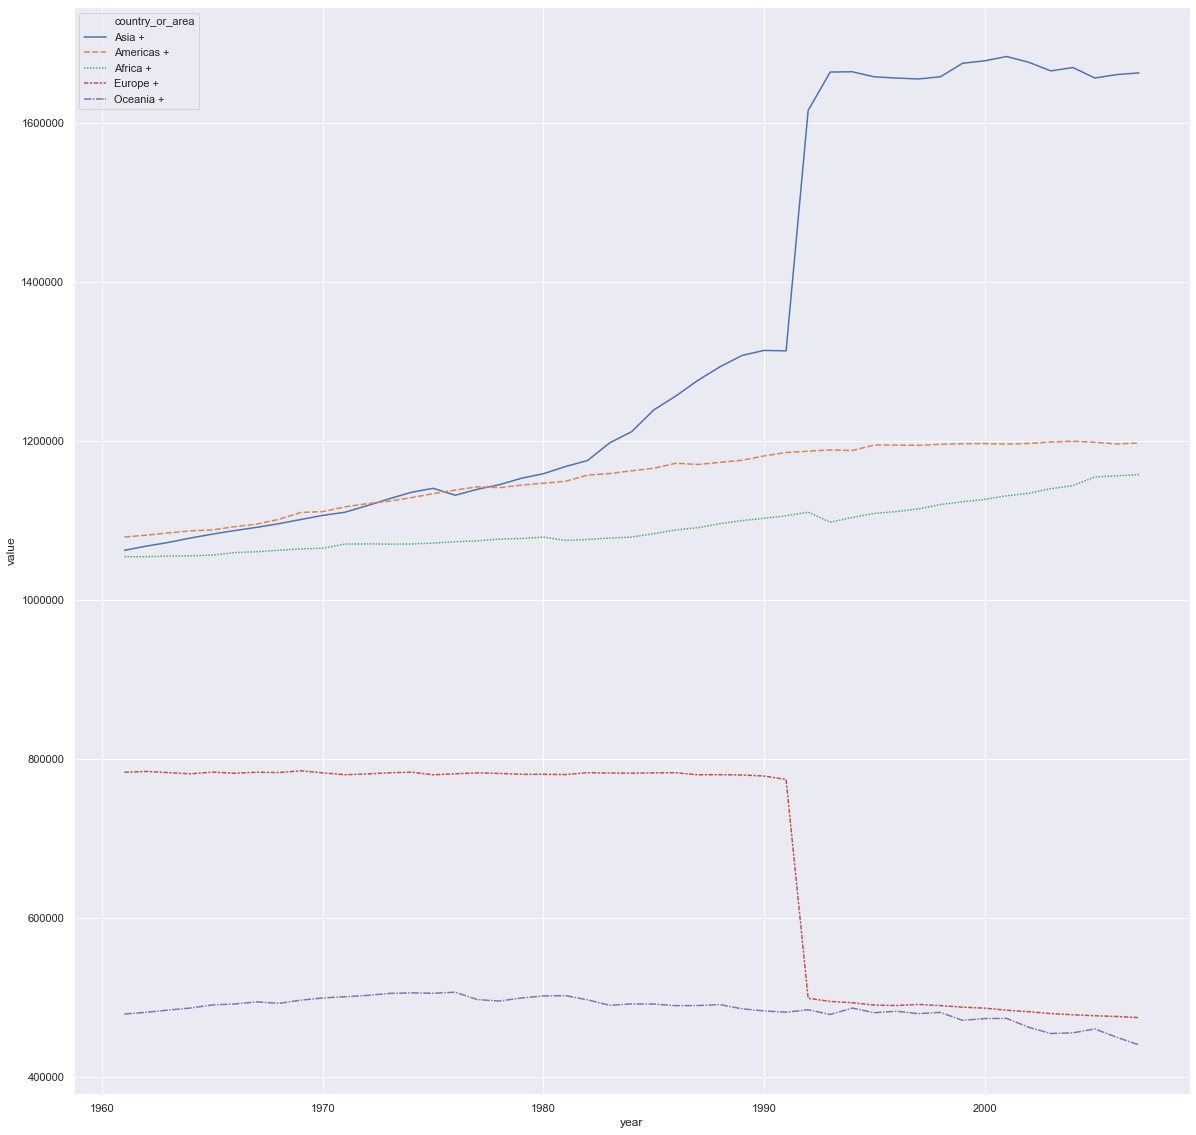

In [4]:
def cond_countries(dataLands):
    countries = ["Asia +","Europe +", "Americas +", "Oceania +", "Africa +"]
    truthTable = (dataLands["country_or_area"] == countries[0])
    for c in countries:
        truthTable = (dataLands["country_or_area"] == c) | truthTable
    return truthTable

dataLandsContinent = dataLands.where(dataLands["category"] == "agricultural_area")\
                                .where(cond_countries(dataLands))\
                                .dropna(subset=["country_or_area"])\
                                .sort_values("value",ascending=False)

sns.set(style="darkgrid")

fg = plt.figure(figsize=(20,20))
axes = fg.add_subplot()
# Plot the responses for different events and regions
sns.lineplot(x="year", y="value", style="country_or_area", data=dataLandsContinent, hue="country_or_area", ax=axes)

fg.show()

Here are the emissions of the BRICS throughout the years. We can see a clear progression (except for South Africa).

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


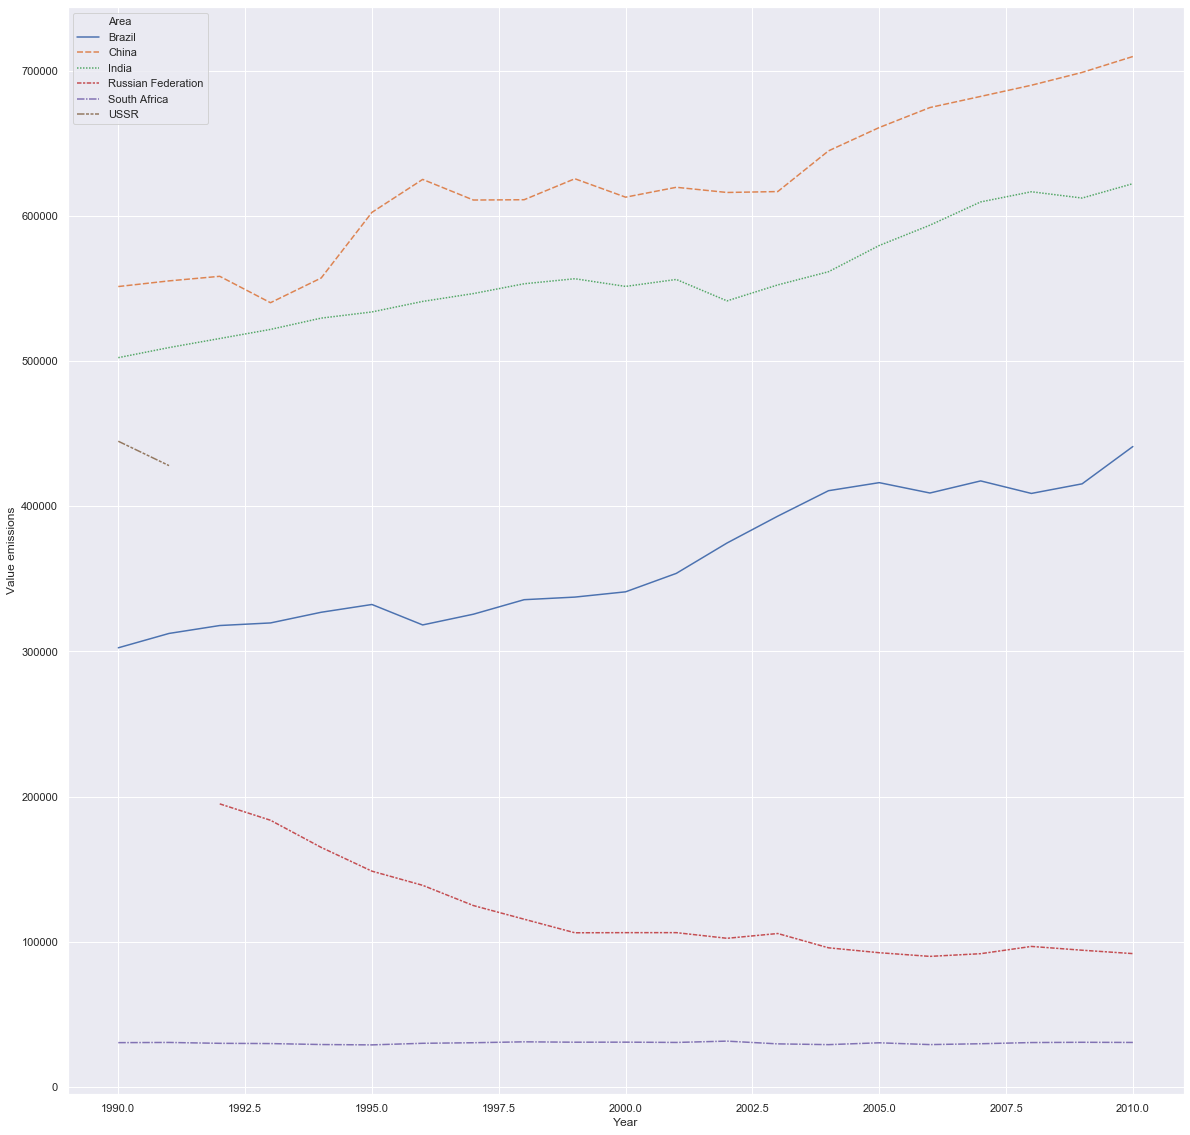

In [5]:
sns.set(style="darkgrid")

dataEmissionsAgrContinent = dataEmissionsAgriculture.where(dataEmissionsAgriculture["Area"].isin(["South Africa","Brazil", "China", "India", "USSR","Russian Federation"])).dropna()

fg = plt.figure(figsize=(20,20))
axes = fg.add_subplot()
# Plot the responses for different events and regions
sns.lineplot(x="Year", y="Value emissions", style="Area", data=dataEmissionsAgrContinent, hue="Area", ax=axes)

fg.show()

## Creating the dataset for processing

The dataset we create for processing consist in the aggregation of the area harvested of for each crop, by year and by country, and the emissions of greenhouse gases by year and by country as well. The goal will be to find a model that explain and helps in predicting the emissions, based on the other features (country, year and crops).

In [6]:
crops = dataCrops.drop(["element_code"], axis=1)\
                .where(dataCrops["element"] == "Area Harvested")\
                .dropna(subset=["element"])\
                .drop(["element", "value_footnotes"],axis=1)\
                .rename(columns={"unit":"Unit area", "value":"Value area", "year":"Year","country_or_area":"Area"})
#                                .where(dataCrops["country_or_area"] == "World +")\
cropsAndEmissions = crops.pivot_table(values='Value area',index=["Area","Year"],columns="category").reset_index()
cropsAndEmissions = cropsAndEmissions.fillna(0)
cropsAndEmissions = pd.merge(cropsAndEmissions, dataEmissionsAgriculture, how="left", on=['Area',"Year"])#.dropna(subset=["Value area", "Value emissions"])
cropsAndEmissions = cropsAndEmissions.dropna().dropna(subset=["Unit emissions"])
cropsAndEmissions

,Area,Year,agave_fibres_nes,almonds_with_shell,anise_badian_fennel_corian,apples,apricots,arecanuts,artichokes,asparagus,...,vegetables_melons_total,vetches,walnuts_with_shell,watermelons,wheat,yams,yautia_cocoyam,Area Code,Unit emissions,Value emissions
29,Afghanistan,1990.0,0.0,5400.0,1300.0,2340.0,5060.0,0.0,0.0,0.0,...,54600.0,0.0,2300.0,8200.0,1570000.0,0.0,0.0,2.0,Gigagrams,7342.7099
30,Afghanistan,1991.0,0.0,5500.0,1300.0,2340.0,5060.0,0.0,0.0,0.0,...,52500.0,0.0,2300.0,7800.0,1690000.0,0.0,0.0,2.0,Gigagrams,7631.0272
31,Afghanistan,1992.0,0.0,5500.0,700.0,2340.0,5060.0,0.0,0.0,0.0,...,52900.0,0.0,2300.0,7800.0,1600000.0,0.0,0.0,2.0,Gigagrams,7631.4427
32,Afghanistan,1993.0,0.0,5500.0,700.0,2300.0,5100.0,0.0,0.0,0.0,...,54900.0,0.0,2300.0,7800.0,1900000.0,0.0,0.0,2.0,Gigagrams,7702.7416
33,Afghanistan,1994.0,0.0,5500.0,700.0,2350.0,5100.0,0.0,0.0,0.0,...,56900.0,0.0,2300.0,7800.0,2000000.0,0.0,0.0,2.0,Gigagrams,7699.1389
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10727,Zimbabwe,2003.0,0.0,0.0,200.0,750.0,20.0,0.0,15.0,60.0,...,25937.0,0.0,0.0,0.0,26500.0,0.0,0.0,181.0,Gigagrams,9779.6837
10728,Zimbabwe,2004.0,0.0,0.0,200.0,750.0,20.0,0.0,17.0,60.0,...,26092.0,0.0,0.0,0.0,26300.0,0.0,0.0,181.0,Gigagrams,10470.7635
10729,Zimbabwe,2005.0,0.0,0.0,200.0,900.0,20.0,0.0,17.0,60.0,...,26242.0,0.0,0.0,0.0,28000.0,0.0,0.0,181.0,Gigagrams,9877.5998
10730,Zimbabwe,2006.0,0.0,0.0,200.0,750.0,20.0,0.0,15.0,60.0,...,23502.0,0.0,0.0,0.0,35000.0,0.0,0.0,181.0,Gigagrams,10053.3116


## Learning to predict emissions

Here, we try to create a model by doing a logistic regression on the data. We first try to optimize the alpha parameter on a predefined interval and then we use it to train the model.

Best alpha is 29.032258064516128 with a MSE of 392737681.6600031 .


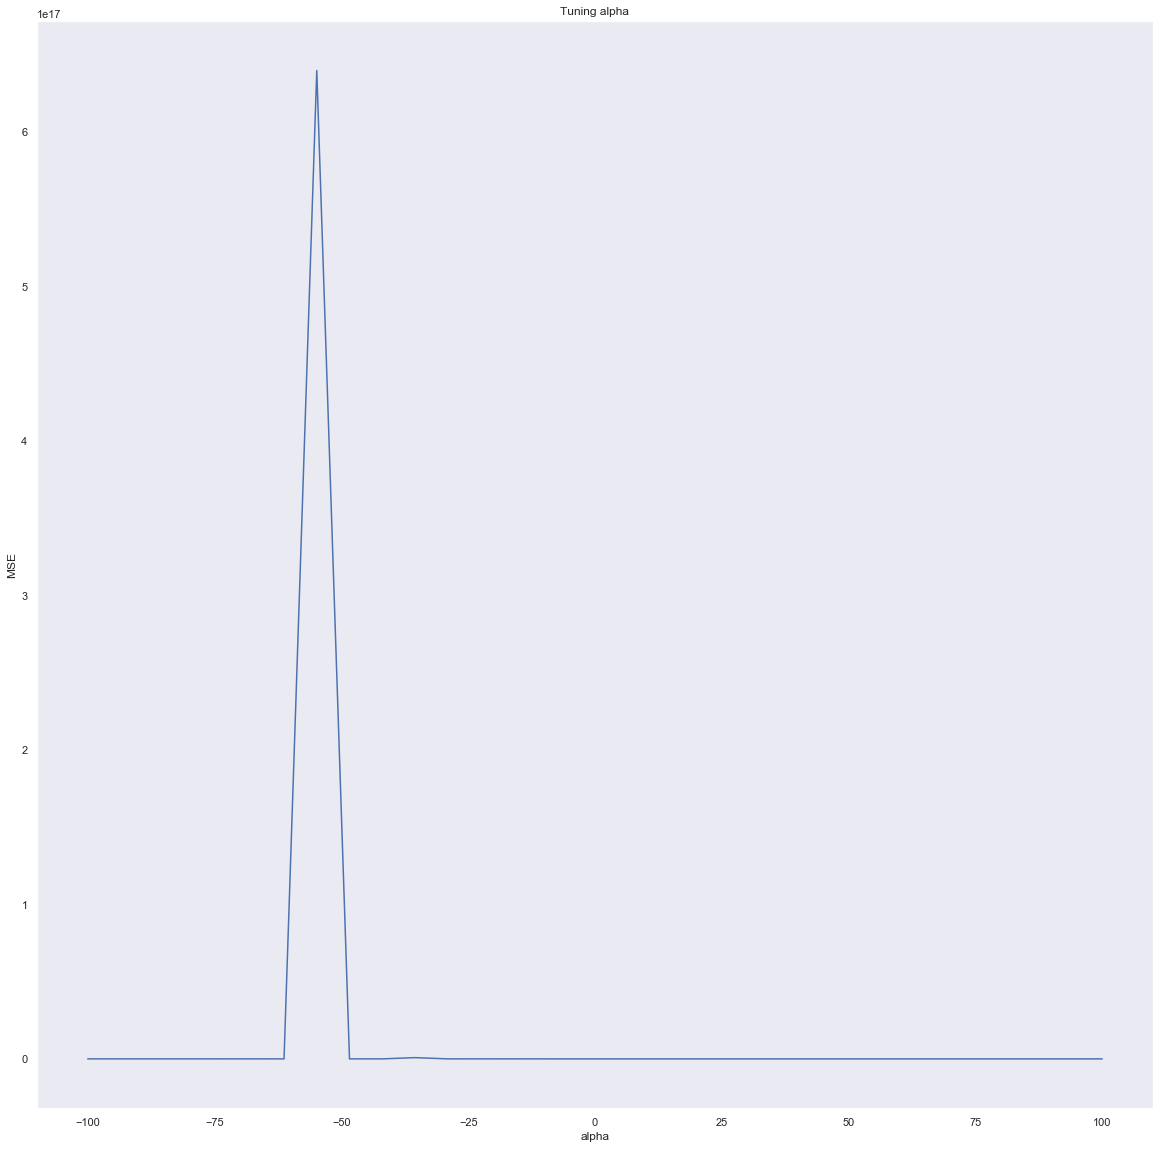

In [7]:
SEED = 1
st_pipeline = Pipeline([('scl', StandardScaler()), ('ridge', Ridge(copy_X=True, random_state=SEED))])
st_pipeline

#features = ["Area","category"]

XRidge2 = pd.get_dummies(cropsAndEmissions.drop(["Area Code","Unit emissions", "Value emissions"], axis=1))
yRidge2 = cropsAndEmissions["Value emissions"]

results = []

# Tune for alpha using 10 fold crossvalidation when calculating the mean squared error.
for alpha in np.linspace(-100, 100, 32):
    st_pipeline.set_params(ridge__alpha= alpha) 
    neg_MSE = cross_val_score(st_pipeline, XRidge2, yRidge2, scoring='neg_mean_squared_error', cv=10)  # we use 10 folds crossvalidation since 10 
                                                                                                      # is pretty much standard in the industry
    results.append([neg_MSE, alpha])
    
# Take the mean MSE for each level of alpha
for i in range(len(results)):
    results[i][0] = -np.mean(results[i][0])
    
# Plot the results
plt.figure(figsize=(20,20))
plt.plot([row[1] for row in results], [row[0] for row in results])
plt.xlabel('alpha')
plt.ylabel('MSE')
plt.title('Tuning alpha');
plt.grid()

best_st_alpha = min(results)[1]
print('Best alpha is', best_st_alpha, 'with a MSE of', min(results)[0],'.')

In [8]:
st_Model = st_pipeline.set_params(ridge__alpha= best_st_alpha)  # use best alpha calculated above
st_Model.fit(XRidge2, yRidge2)                                  # fit the new model

Pipeline(memory=None,
         steps=[('scl',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('ridge',
                 Ridge(alpha=29.032258064516128, copy_X=True,
                       fit_intercept=True, max_iter=None, normalize=False,
                       random_state=1, solver='auto', tol=0.001))],
         verbose=False)

In [9]:
#st_Model.named_steps["ridge"].coef_
weights = pd.DataFrame([XRidge2.columns,st_Model.named_steps["ridge"].coef_]).transpose().sort_values(1)
weights

,0,1
91,mushrooms_and_truffles,-2158.66
107,other_melons_inc_cantaloupes,-2080.23
356,Area_Ukraine,-1600.37
301,Area_Nigeria,-1505.16
216,Area_Cuba,-1482.57
...,...,...
195,Area_Brazil,3906.77
143,soybeans,3947.84
83,maize,4543.2
179,Area_Australia,6052.34


Further analysis will be conducted in order to create efficient predictions. This first analysis already gave us clear insight of the data and helps us in assessing the feasability of this research.

## Plan

The next steps will be :

- Visualize the output of the model and its relation to reality.
- Try new models and assess their performances.
- Make predictions on the future using these regressions.
- Extract guidelines that could help in reducing emissions in the future, based on these data.
- Criticize these guidelines and the predictions using more domain-related knowledge.

# Output of the model

In [10]:
weights.columns = ["name", "weight"]

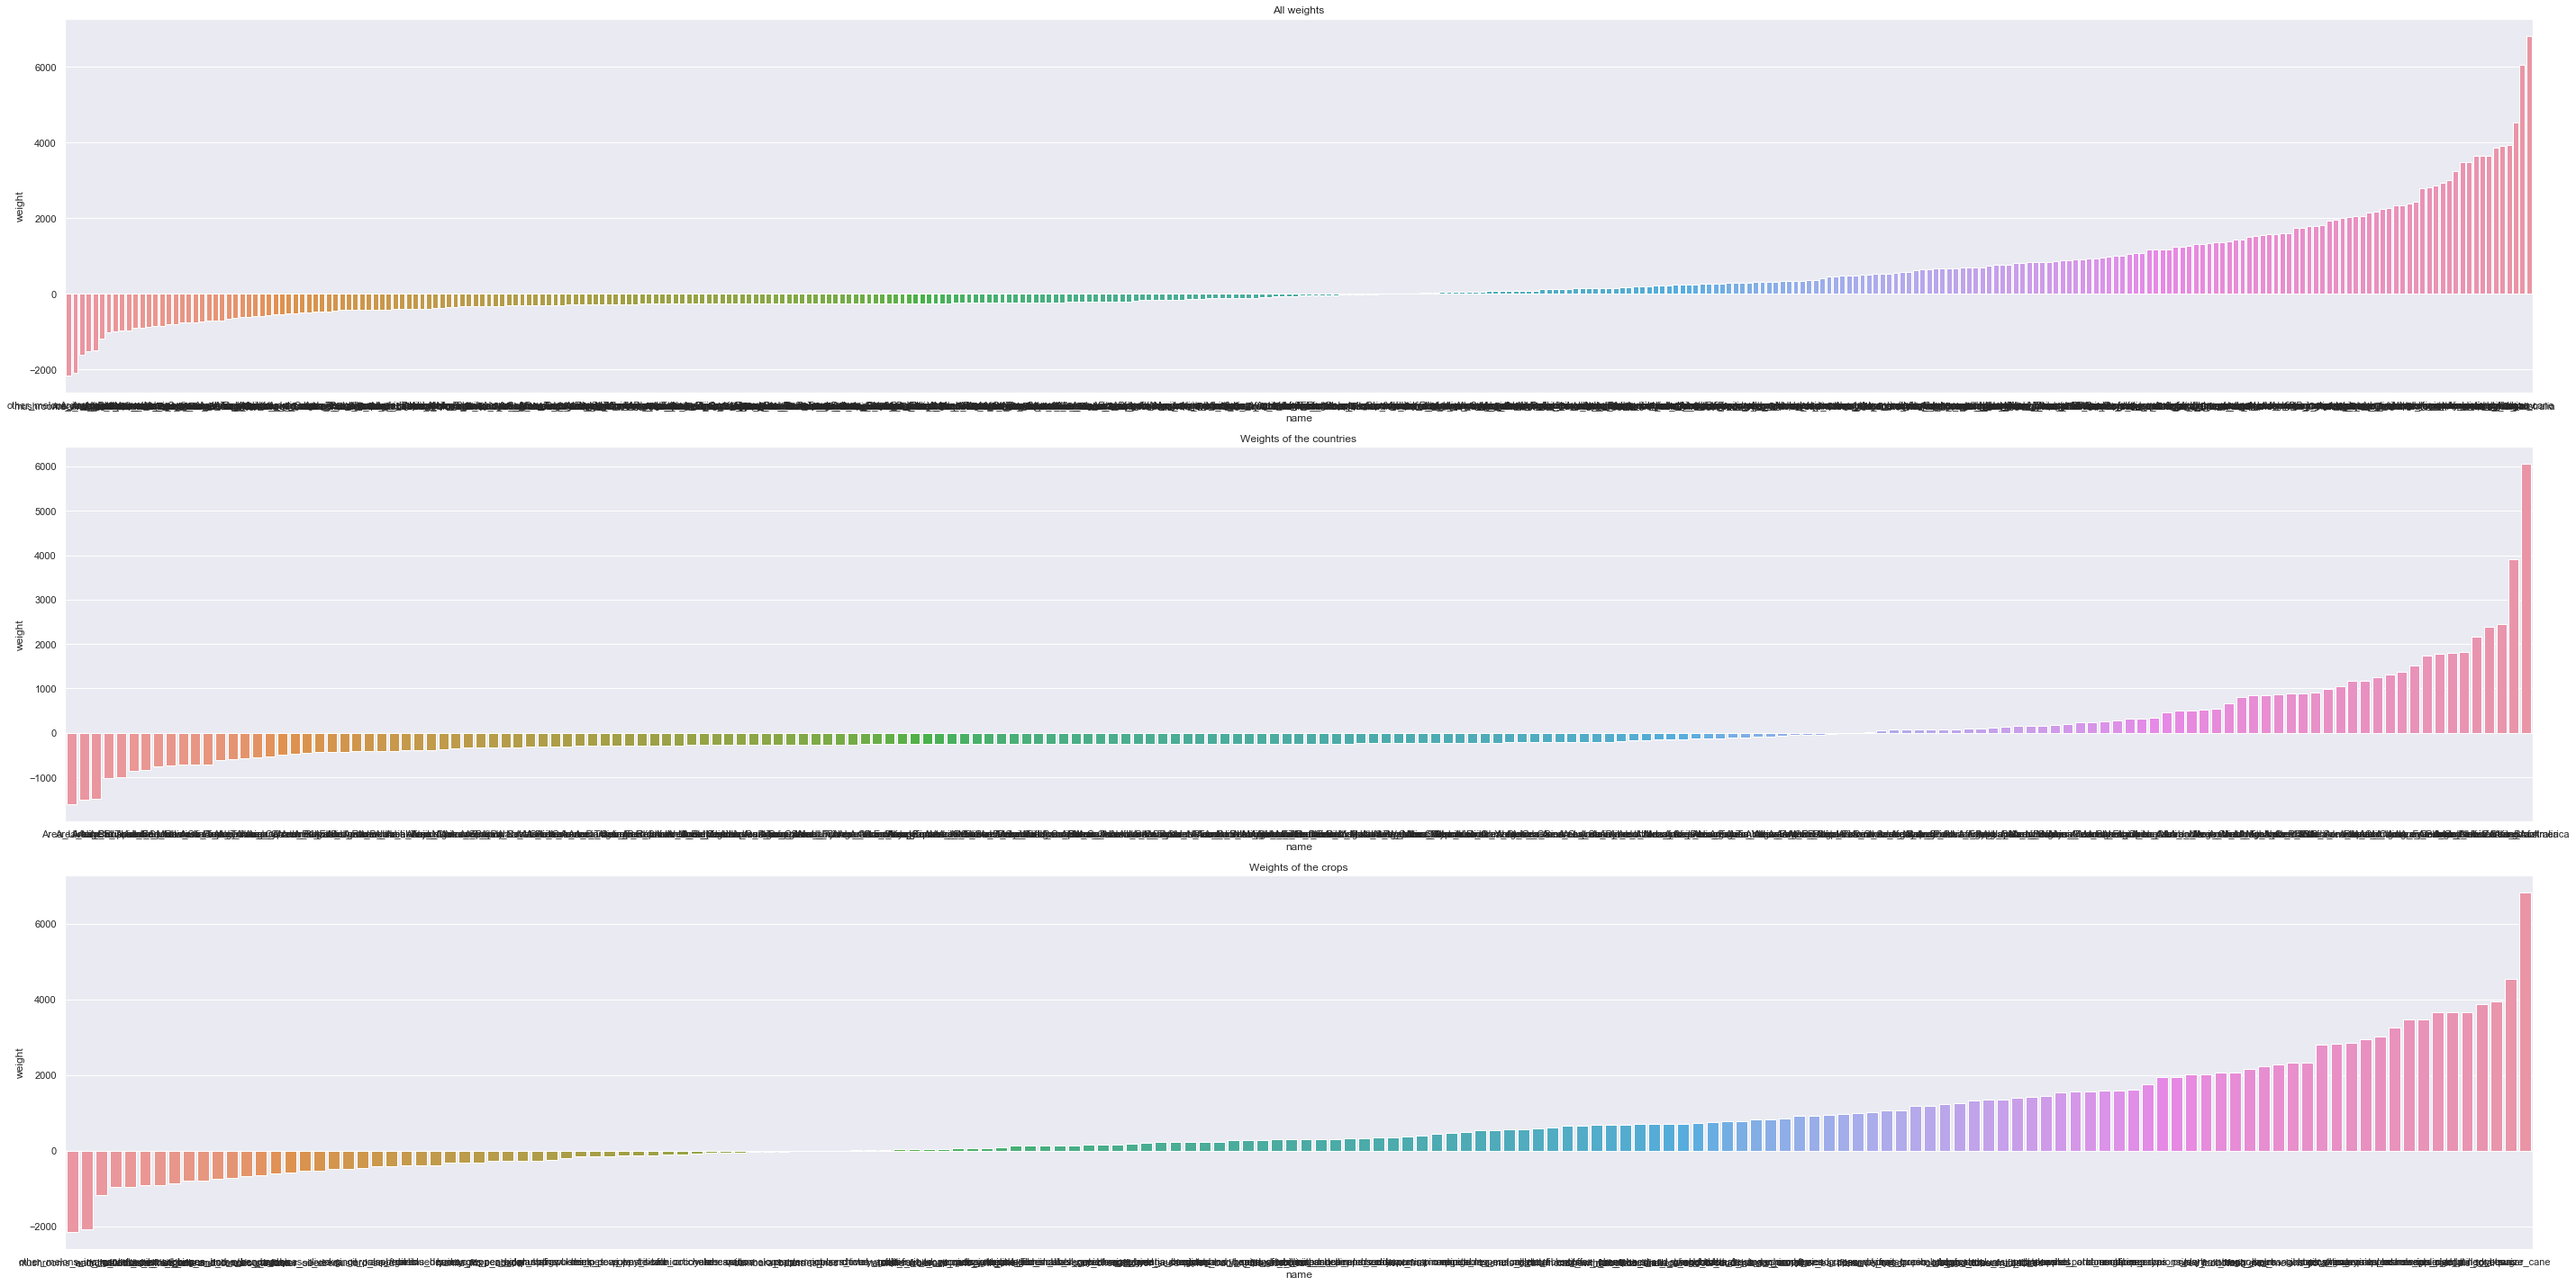

In [11]:
fg = plt.figure(figsize=(40,20))

axes1 = fg.add_subplot(3,1,1)
sns.barplot(x="name", y="weight", data=weights, ax=axes1)
axes1.set_title("All weights")

axes2 = fg.add_subplot(3,1,2)
sns.barplot(x="name", y="weight", data=weights.where(weights.name.str.contains("Area")).dropna(), ax=axes2)
axes2.set_title("Weights of the countries")

axes3 = fg.add_subplot(3,1,3)
sns.barplot(x="name", y="weight", data=weights.mask(weights.name.str.contains("Area")).mask(weights.name == "Year").dropna(), ax=axes3)
axes3.set_title("Weights of the crops")

fg.tight_layout()

In [12]:
weights.where(weights.name.str.contains("Area")).where(weights.weight > 0).dropna().sort_values("weight")#.where("weight > 0")

,name,weight
339,Area_Sweden,13.2048
325,Area_Senegal,63.8552
266,Area_Kenya,67.8984
303,Area_Norway,69.4197
180,Area_Austria,71.6935
309,Area_Peru,75.0356
334,Area_South Africa,76.5428
340,Area_Switzerland,76.5858
226,Area_Egypt,88.2928
187,Area_Belgium,89.551


In [13]:
weights.mask(weights.name.str.contains("Area")).where(weights.weight > 0).dropna().sort_values("weight").head()

,name,weight
125,pulses_total,5.18685
0,Year,9.79324
41,cloves,11.7426
35,chicory_roots,14.0448
162,vanilla,22.7541


## New model for predictions

In order to obtain better predictions, we decided to restart the process. Using linear regressions, we compute the emissions produced by each crops.

In [14]:
crops = dataCrops.drop(["element_code"], axis=1)\
                .where(dataCrops["element"] == "Area Harvested")\
                .mask(dataCrops.country_or_area.isin(["Asia +","Europe +", "Americas +", "Oceania +", "Africa +"]))\
                .dropna(subset=["element"])\
                .drop(["element", "value_footnotes"],axis=1)\
                .rename(columns={"unit":"Unit area", "value":"Value area", "year":"Year","country_or_area":"Area"})
crops.head(5)

,Area,Year,Unit area,Value area,category
282,Caribbean +,2007.0,Ha,10000.0,agave_fibres_nes
283,Caribbean +,2006.0,Ha,10000.0,agave_fibres_nes
284,Caribbean +,2005.0,Ha,10000.0,agave_fibres_nes
285,Caribbean +,2004.0,Ha,10000.0,agave_fibres_nes
286,Caribbean +,2003.0,Ha,10000.0,agave_fibres_nes


In [15]:
listCountries = ["United States of America", "India", "Switzerland", "United Kingdom", "China"]
filterCrops = ["cereals_total", "cereals_rice_milled_eqv","pulses_total", "coarse_grain_total", "treenuts_total"]

#cropsEmissionsNormalized = crops.where(crops.Area.isin(listCountries)).dropna()
cropsEmissionsNormalized = crops
totalHarvestedArea = cropsEmissionsNormalized.groupby(["Area","Year"]).sum()#.drop(["Year"], axis=1)#.rename("Value area", "Total area harvested")
totalHarvestedArea.columns = ["Total area harvested"]
cropsEmissionsNormalized = pd.merge(cropsEmissionsNormalized, totalHarvestedArea, how="left", on=['Area',"Year"])
cropsEmissionsNormalized = pd.merge(cropsEmissionsNormalized, dataEmissionsAgriculture, how="left", on=['Area',"Year"])#.dropna(subset=["Value area", "Value emissions"])
cropsEmissionsNormalized = cropsEmissionsNormalized.dropna().dropna(subset=["Unit emissions"])
cropsEmissionsNormalized["Value emissions"] = cropsEmissionsNormalized["Value area"]*cropsEmissionsNormalized["Value emissions"]/(cropsEmissionsNormalized["Total area harvested"]*cropsEmissionsNormalized["Total area harvested"])
cropsEmissionsNormalized = cropsEmissionsNormalized.mask(cropsEmissionsNormalized.category.isin(filterCrops)).dropna()
cropsEmissionsNormalized.head(5)

,Area,Year,Unit area,Value area,category,Total area harvested,Area Code,Unit emissions,Value emissions
94,Colombia,2007.0,Ha,17500.0,agave_fibres_nes,8073504.0,44.0,Gigagrams,0.000016
95,Colombia,2006.0,Ha,17500.0,agave_fibres_nes,7727624.0,44.0,Gigagrams,0.000016
96,Colombia,2005.0,Ha,17500.0,agave_fibres_nes,9095840.0,44.0,Gigagrams,0.000012
97,Colombia,2004.0,Ha,17294.0,agave_fibres_nes,9330644.0,44.0,Gigagrams,0.000011
98,Colombia,2003.0,Ha,17094.0,agave_fibres_nes,8884880.0,44.0,Gigagrams,0.000012


**cropsEmissionsNormalized** is a dataframe containing the value of emissions per crops, per country and per year. The total emissions for a given country and a given year was split over the different crops using their ratio of harvested area over the total harvested area. Then, these emissions were again normalized by the total harvested area, in order to obtain comparable results above all the countries. 

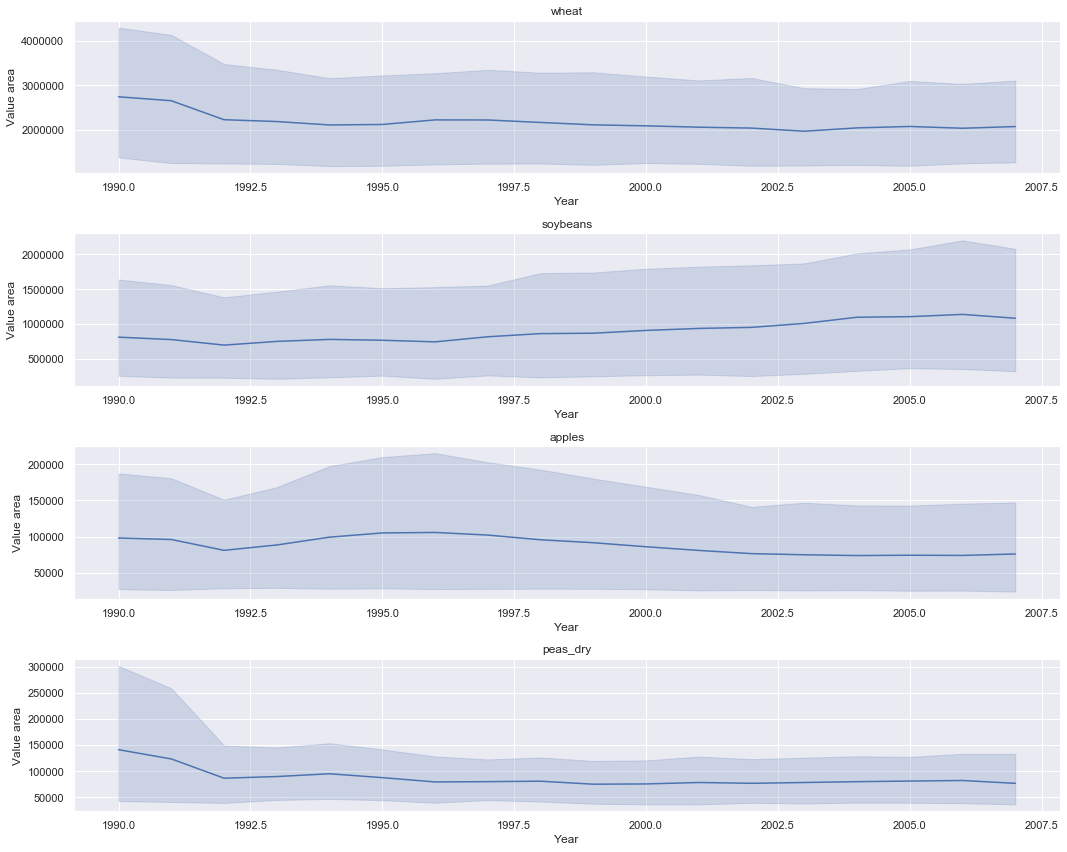

In [16]:
fg = plt.figure(figsize=(15,12))

i = 1

listCrops = ["wheat","soybeans", "apples", "peas_dry"]

for c in listCrops:
    #print(cropsEmissionsNormalized.where(cropsEmissionsNormalized.Area == c).dropna())
    axes = fg.add_subplot(len(listCrops),1,i)
    sns.lineplot(x="Year", y="Value area",\
                data=cropsEmissionsNormalized.where(cropsEmissionsNormalized.category == c).dropna(),\
                ax=axes)
    axes.set_title(c)
    i = i+1

fg.tight_layout()

On the graph above, you can see the evolution in time of the *area harvested* for different crops. Except for *wheat*, there is a slight increase for each of the above. It is strange if we compare this to the evolution of the population, which more or less doubled during the last 3 decades. This could be explained by the industrialization of the agriculture, which requires less area to produce a similar amount of food.

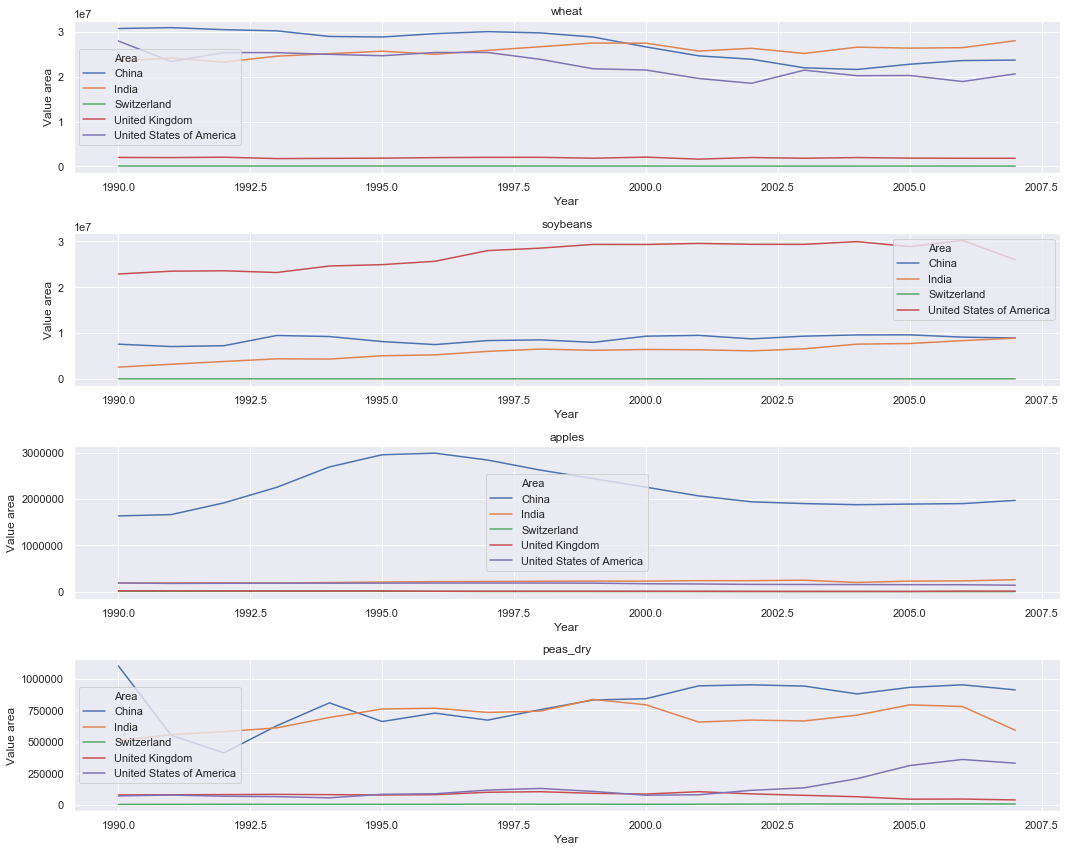

In [17]:
fg = plt.figure(figsize=(15,12))

i = 1

listCrops = ["wheat","soybeans", "apples", "peas_dry"]

for c in listCrops:
    #print(cropsEmissionsNormalized.where(cropsEmissionsNormalized.Area == c).dropna())
    axes = fg.add_subplot(len(listCrops),1,i)
    sns.lineplot(x="Year", y="Value area", hue="Area",\
                data=cropsEmissionsNormalized.where(cropsEmissionsNormalized.category == c)\
                 .where(cropsEmissionsNormalized.Area.isin(listCountries)).dropna(),\
                ax=axes)
    axes.set_title(c)
    i = i+1

fg.tight_layout()

This graph gives a preview of the evolution of these crops for each country. They all follow the overall evolution and none of them demonstrate a clear increase or decrease in the harvesting of these crops.

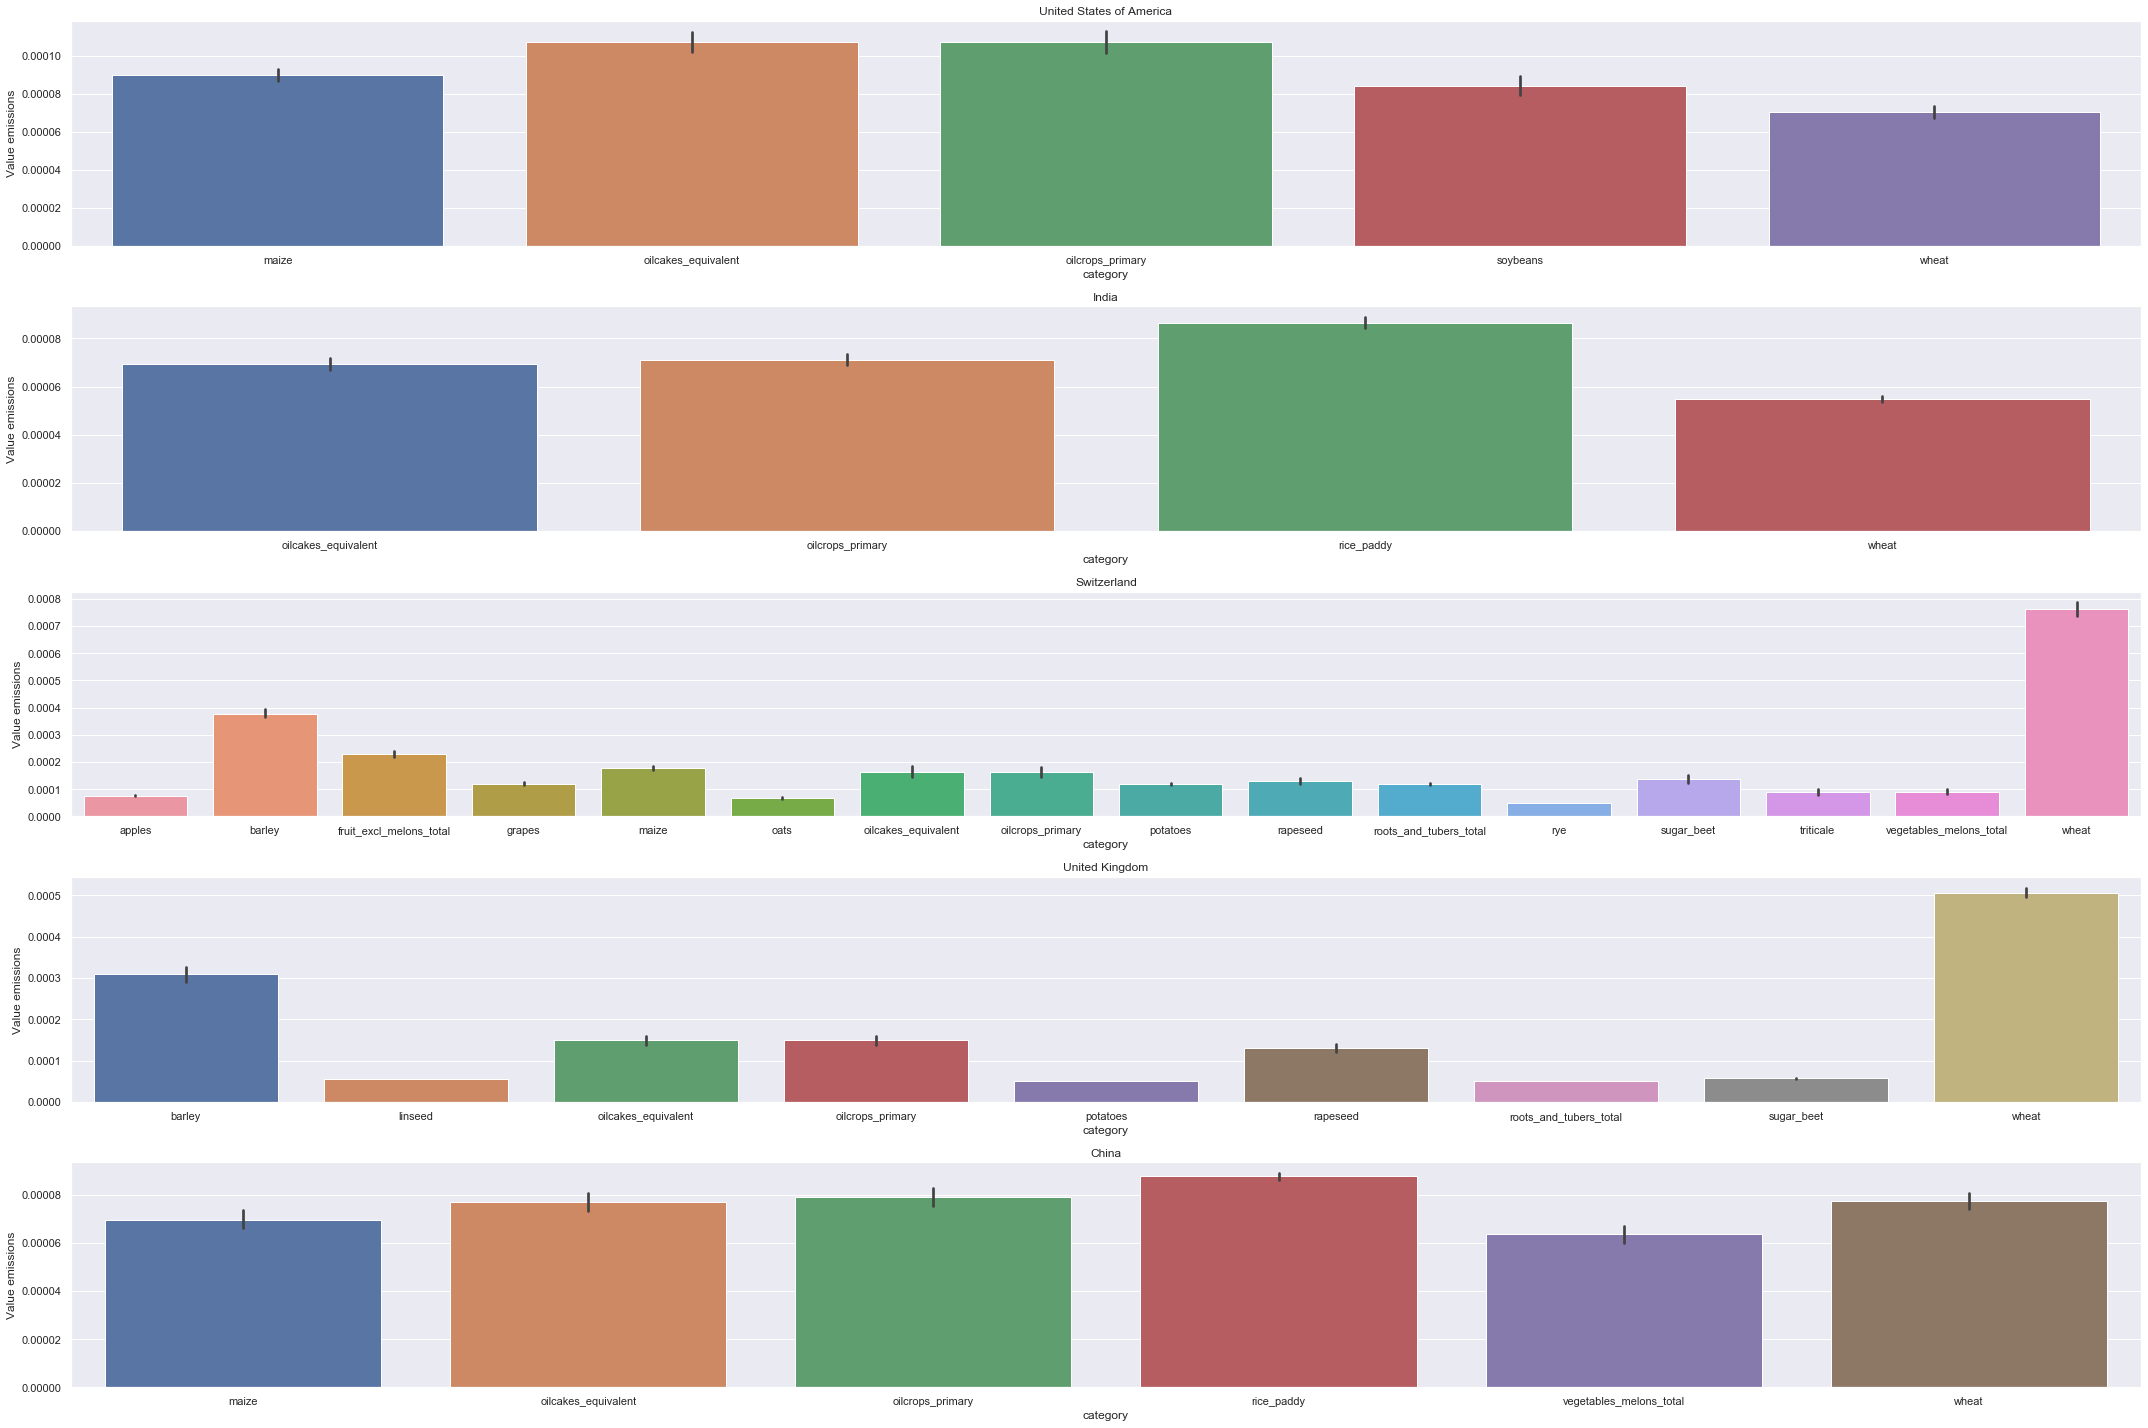

In [18]:
fg = plt.figure(figsize=(30,20))

i = 1

for c in listCountries:
    #print(cropsEmissionsNormalized.where(cropsEmissionsNormalized.Area == c).dropna())
    axes = fg.add_subplot(5,1,i)
    try:
        sns.barplot(x="category", y="Value emissions",\
                    data=cropsEmissionsNormalized.where(cropsEmissionsNormalized.Area == c).where(cropsEmissionsNormalized["Value emissions"] > 0.00005).dropna(),\
                    ax=axes)
    except ValueError as e:
        print(str(e))
    axes.set_title(c)
    i = i+1

fg.tight_layout()

In the plot above, we show the **normalized emissions values** for the considered countries and we only display the crops that are the most "emitting". One very interesting fact is that Switzerland as well as UK seems to have a really considerable number of crops they grow that emits over the threshold we set. In order to investigate this, we made the graph below.

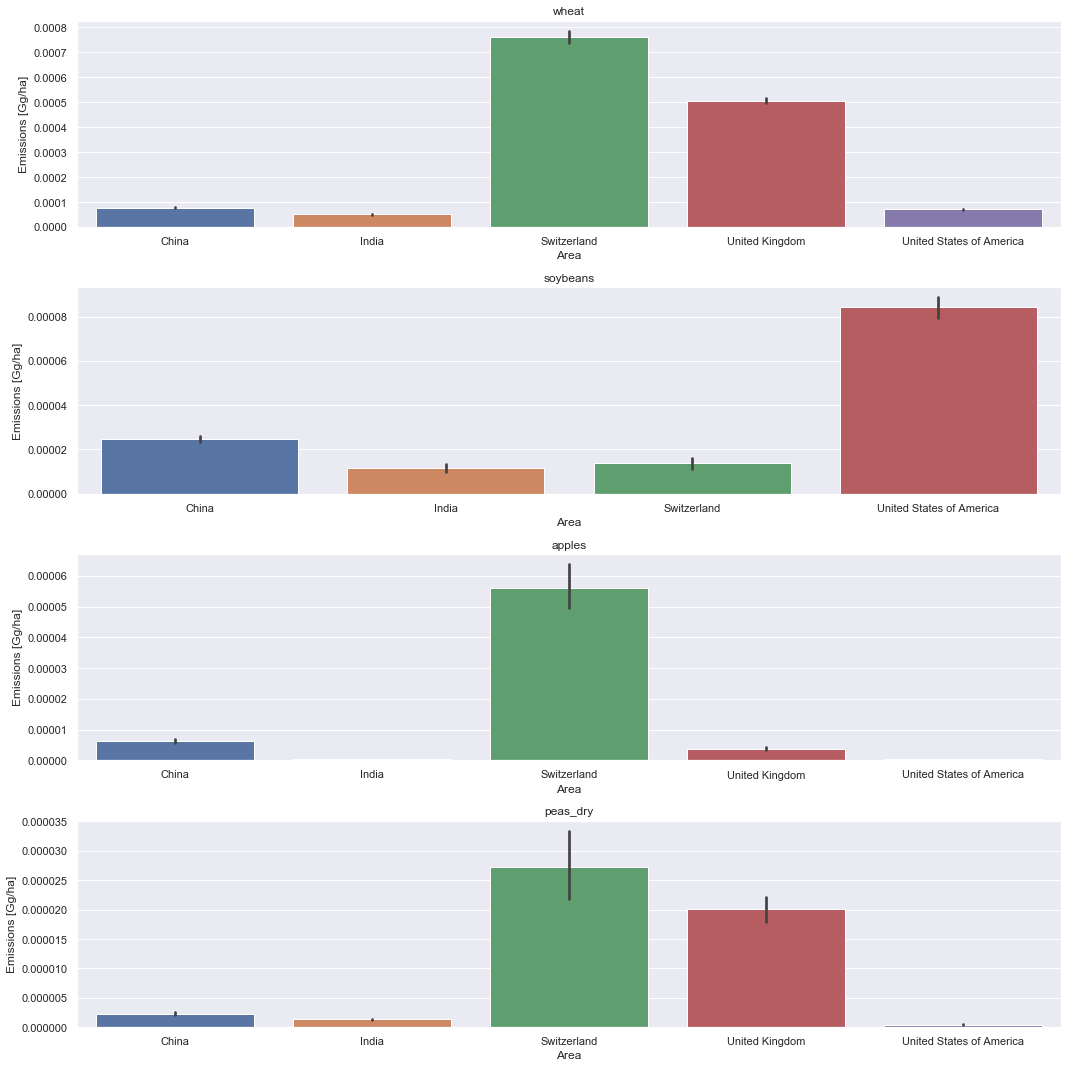

In [19]:
fg = plt.figure(figsize=(15,15))

i = 1

for c in listCrops:
    #print(cropsEmissionsNormalized.where(cropsEmissionsNormalized.Area == c).dropna())
    axes = fg.add_subplot(len(listCrops),1,i)
    try:
        sns.barplot(x="Area", y="Value emissions",\
                    data=cropsEmissionsNormalized.where(cropsEmissionsNormalized.Area.isin(listCountries)).where(cropsEmissionsNormalized["category"] == c).dropna(),\
                    ax=axes)
    except ValueError as e:
        print(str(e))
    axes.set_title(c)
    axes.set_ylabel("Emissions [Gg/ha]")
    i = i+1

fg.tight_layout()

fg.savefig("emissions_by_unit_area_crop.eps")

This graph shows for 4 different crops, their normalized emissions value, aggregated in time. This is very insightful as it appears systematically that producing one of this type of crop in Switzerland, in UK or in US for the soybeans, emits more greenhouse gas than producing this in China or in India. This could be the consequence of the size of the production. Lets now compare the area harvested for each of these crops in these countries.

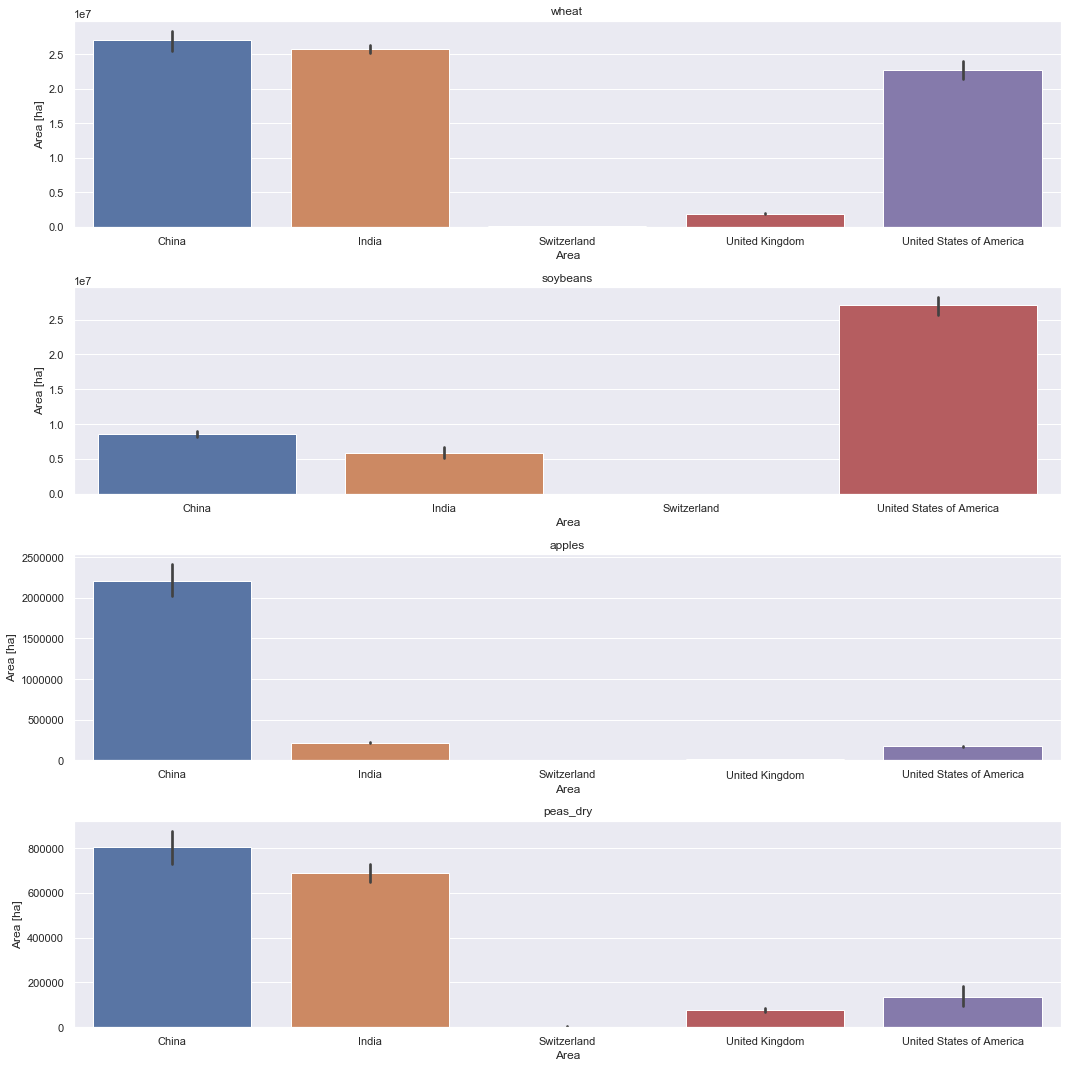

In [20]:
fg = plt.figure(figsize=(15,15))

i = 1
listCrops = ["wheat","soybeans", "apples", "peas_dry"]

for c in listCrops:
    #print(cropsEmissionsNormalized.where(cropsEmissionsNormalized.Area == c).dropna())
    axes = fg.add_subplot(len(listCrops),1,i)
    try:
        sns.barplot(x="Area", y="Value area",\
                    data=cropsEmissionsNormalized.where(cropsEmissionsNormalized.Area.isin(listCountries)).where(cropsEmissionsNormalized["category"] == c).dropna(),\
                    ax=axes)
    except ValueError as e:
        print(str(e))
    axes.set_title(c)
    axes.set_ylabel("Area [ha]")
    i = i+1

fg.tight_layout()
fg.savefig("area_crop.eps")

Here you clearly see that the production in China and in India are considerably bigger than those in United Kingdom or Switzerland. Therefore, we could argue that producing more is more efficient. However, the case of soybeans counterbalance this argument as the US is at the same time the biggest producer and least efficient producer of soybeans in terms of gas emissions. This could be put in relation with many other factors such as:

- human vs machine use in fields,
- automatisation,
- technical knowledge in agriculture,
- fertilizer and pesticide use.

## Create a model to assess the environmental efficiency for each crop

We will know create a model to predict the efficiency of each crop. This model will then be used to compute the emissions related to each crop in the near future. Based on this, we will also create a model to predict the agriculture type in each country in terms of crop development and area use in the next years. By combinig these two models, we will then try to predict the overall emissions for each country.

In [21]:
def create_model_for_crop(crop):
    cropData = cropsEmissionsNormalized.where(cropsEmissionsNormalized.category ==crop).dropna()
    lm = LinearRegression()
    
    cropData = cropData.groupby("Year").sum().reset_index()

    X = cropData[["Year"]]
    Y = cropData[["Value emissions"]]

    lm.fit(X,Y)
    
    return lm

models = []

for crop in cropsEmissionsNormalized.category.unique():
    models.append((crop,create_model_for_crop(crop)))
    
cropsModelsEmissionsPerUnitArea = pd.DataFrame(models, columns=("crop","model_emissions"))

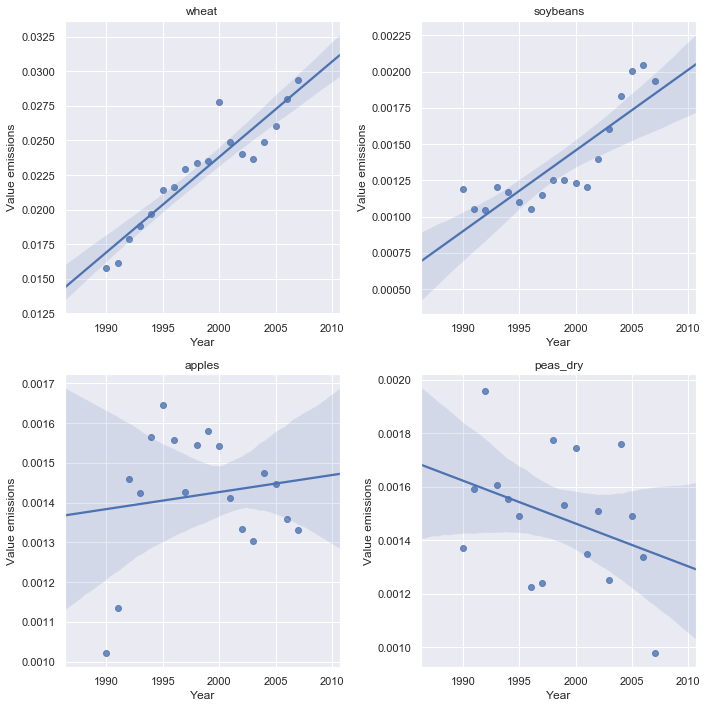

In [22]:
fg = plt.figure(figsize=(10,10))

i = 1
listCrops = ["wheat","soybeans", "apples", "peas_dry"]

for c in listCrops:
    #print(cropsEmissionsNormalized.where(cropsEmissionsNormalized.Area == c).dropna())
    axes = fg.add_subplot(2,2,i)
    cropData = cropsEmissionsNormalized.where(cropsEmissionsNormalized["category"] == c)\
                                        .dropna()\
                                        .groupby("Year").sum().reset_index()
    try:
        sns.regplot(x="Year", y="Value emissions",\
                    data=cropData,\
                    ax=axes)
    except ValueError as e:
        print(str(e))
    axes.set_title(c)
    i = i+1

fg.tight_layout()
fg.savefig("emissions_per_crop_prediction.pdf")

As it can be seen, some crops have a strong linear dependency while other crops can have very sparse data and a probably difficult to predict behaviour. In some cases it is very relevant to make linear regressions. For the sake of simplicity, we will keep the linear regressions for all the crops.

In [23]:
def get_model_crop(crop, cropsData):
    cropsData = cropsData.where(cropsData.category ==crop).dropna()
    
    lm = LinearRegression()
    
    cropsData = cropsData.groupby("Year").sum().reset_index()
    
    X = cropsData[["Year"]]
    Y = cropsData[["Value area"]]
    
    try:
        lm.fit(X,Y)
    except ValueError as e:
        #print(str(e))
        return np.nan
    
    return lm

def get_model_crops_country(country):
    cropsData = cropsEmissionsNormalized.where(cropsEmissionsNormalized.Area ==country).dropna()
    
    models = []

    for crop in cropsEmissionsNormalized.category.unique():
        models.append((crop,get_model_crop(crop, cropsData)))
    
    cropsModelsGrowth = pd.DataFrame(models, columns=("crop","model_growth"))
    
    return cropsModelsGrowth

class PredictorEmissionsCountry():
    def __init__(self, country, modelCrops, modelEmissionsByCrops):
        self.country = country
        self.modelCrops = modelCrops
        self.modelEmissionsByCrops = modelEmissionsByCrops
        
    def predict_emissions(self, startYear, endYear):
        years = []
        for i in range(startYear, endYear):
            years.append(i)
            
        def compute_production_area(row):
            return (row.model_growth.predict(pd.DataFrame(years)),)
        def compute_emissions_per_unit_area(row):
            return (row.model_emissions.predict(pd.DataFrame(years)),)
        def compute_emissions_per_unit_area(row):
            return (row.model_emissions.predict(pd.DataFrame(years)),)
        def compute_emissions(row):
            return (row.production_area*row.emissions_per_unit_area,)
        def flatten(arr):
            flatArr = []
            for i in arr:
                flatArr.append(i[0])
            return flatArr

        m = pd.merge(self.modelCrops, self.modelEmissionsByCrops, how="left", on=['crop']).dropna()
        m = m.join(m.apply(compute_production_area, axis=1, result_type="expand")).rename(columns={0:"production_area"})
        
        m = m.join(m.apply(compute_emissions_per_unit_area, axis=1, result_type="expand")).rename(columns={0:"emissions_per_unit_area"})
        m = m.join(m.apply(compute_emissions, axis=1, result_type="expand")).rename(columns={0:"emissions"})
        m.emissions = m.emissions.apply(flatten)
        m = pd.DataFrame(m.emissions.tolist(), columns=years)

        m = m.sum(0)
        return pd.DataFrame(m,columns=["emissions"]).reset_index().rename(columns={"index":"year"})

def get_model_emissions_countries(listCountries):
    #get_model_crops_country(country)
    
    predictorsEmissions = []

    for country in cropsEmissionsNormalized.where(cropsEmissionsNormalized.Area.isin(listCountries)).dropna().Area.unique():
        predictorsEmissions.append(PredictorEmissionsCountry(country,\
                                                            get_model_crops_country(country),\
                                                            cropsModelsEmissionsPerUnitArea))
        print("Predictor for " + country + " done.")
    
    return predictorsEmissions

Predictor for China done.
Predictor for United States of America done.
Predictor for India done.
Predictor for Switzerland done.
Predictor for United Kingdom done.


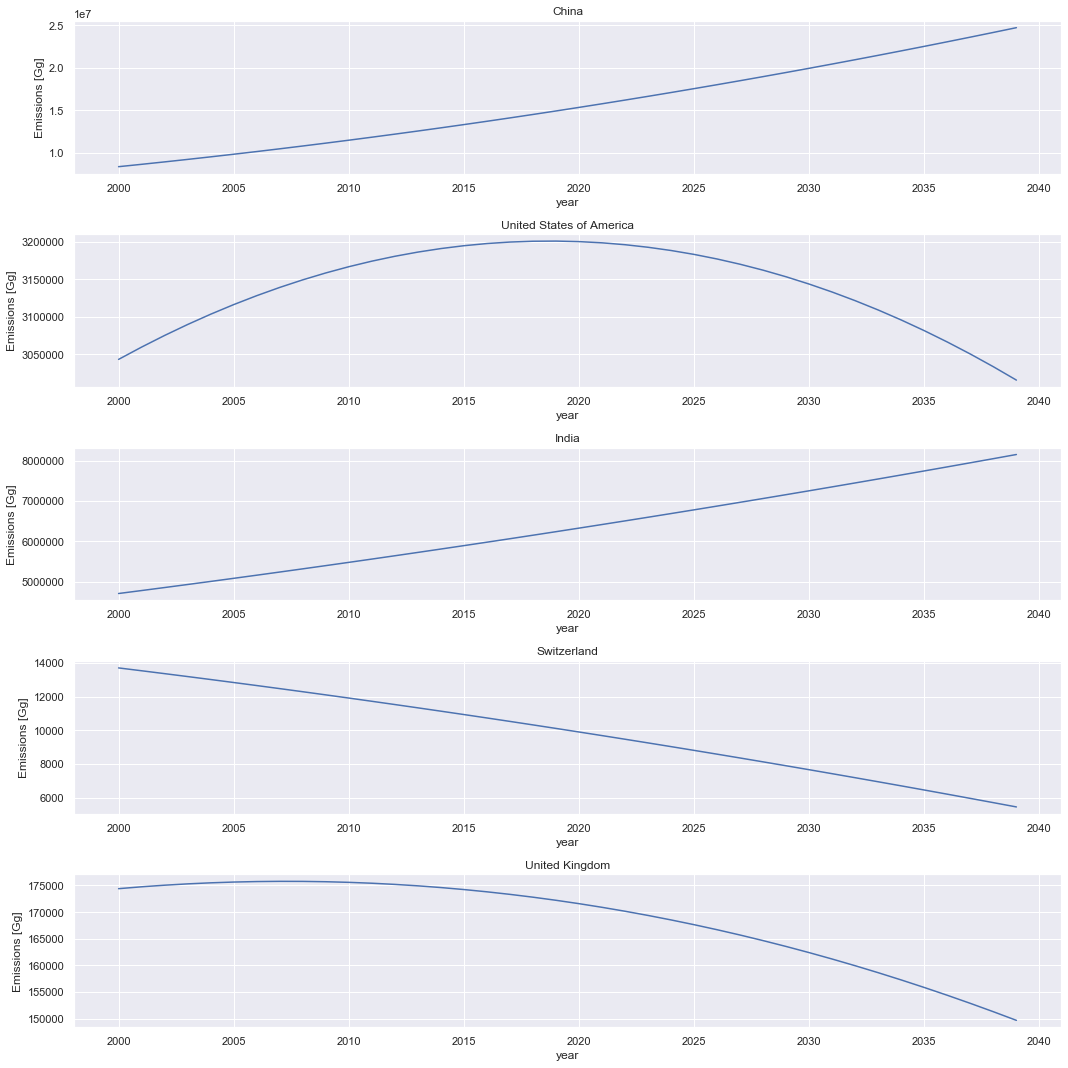

In [24]:
models = get_model_emissions_countries(listCountries)

fg = plt.figure(figsize=(15,15))

i = 1

for mc in models:
    #print(cropsEmissionsNormalized.where(cropsEmissionsNormalized.Area == c).dropna())
    emissions = mc.predict_emissions(2000,2040)
    axes = fg.add_subplot(5,1,i)
    try:
        sns.lineplot(x="year", y="emissions",data=emissions,\
                    ax=axes)
    except ValueError as e:
        print(str(e))
    axes.set_title(mc.country)
    axes.set_ylabel("Emissions [Gg]")
    i = i+1

fg.tight_layout()
fg.savefig("emissions_prediction.eps")

Using the model above, these are the predictions for the emissions of the selected countries. It is very impressive to see how China and India, which could still be considered as developping countries if we consider the life quality of the poorest part of the population, have continuously increasing emissions. However, more developped countries such as US, UK and Switzerland seems to be able to mitigate and reverse the growth of their emissions.

# **Question 3 initial exploration**

Is it possible to rank some patterns of land usage with social and environmental factors such as employment, life satisfaction (if data are presents), income inequalities (if data are presents), emissions and finally soil quality and sustainability?

To answer this question we will need to acquire additionnal data, but before doing that, we must define the **scope** of the question. It doesn't really make sense to aggregate countries into continents since the social factors are really specific to each country. Therefore, we reduce our scope to a list of 12 countries that we are interested in and feel are important.

In [25]:
countries = ['France', 'Canada', 'Germany', 'India', 'Japan', 'Russian Federation', 'Switzerland', 'United States of America', 'United Kingdom', 'China', 'Israel']

## Data acquisition and cleaning

In [26]:
dataLands = pd.read_csv("./data/fao_data_land_data.csv")
dataLands.head()

,country_or_area,element_code,element,year,unit,value,value_footnotes,category
0,Afghanistan,11,Area,2007.0,1000 Ha,38661.0,Q,agricultural_area
1,Afghanistan,11,Area,2006.0,1000 Ha,38659.0,Fm,agricultural_area
2,Afghanistan,11,Area,2005.0,1000 Ha,38515.0,Fm,agricultural_area
3,Afghanistan,11,Area,2004.0,1000 Ha,38064.0,Fm,agricultural_area
4,Afghanistan,11,Area,2003.0,1000 Ha,38899.0,Fm,agricultural_area


In [27]:
# investigate NaN values
dataLands[np.isnan(dataLands['value'].values)].head(3)

,country_or_area,element_code,element,year,unit,value,value_footnotes,category
11154,fnSeqID,Footnote,NaN,NaN,NaN,NaN,NaN,agricultural_area
11155,W,Data reported on country official publications...,NaN,NaN,NaN,NaN,NaN,agricultural_area
11156,E,Expert sources from FAO (including other divis...,NaN,NaN,NaN,NaN,NaN,agricultural_area


We observe that the dataset is pretty clean. The only NaNs in 'value' column are actually the footnotes so we can drop them.

In [28]:
dataLands = dataLands.dropna(subset=["value"])
dataLands.tail(3)

,country_or_area,element_code,element,year,unit,value,value_footnotes,category
104773,Zimbabwe,11,Area,1963.0,1000 Ha,23.0,Q,total_area_equipped_for_irrigation
104774,Zimbabwe,11,Area,1962.0,1000 Ha,23.0,Q,total_area_equipped_for_irrigation
104775,Zimbabwe,11,Area,1961.0,1000 Ha,22.0,Q,total_area_equipped_for_irrigation


In [29]:
print(dataLands['category'].unique().tolist())

# we only keep agricultural area
dataLands = dataLands[dataLands['category'] == 'agricultural_area']

['agricultural_area', 'agricultural_area_irrigated', 'arable_land', 'arable_land_and_permanent_crops', 'country_area', 'fallow_land', 'forest_area', 'inland_water', 'land_area', 'other_land', 'perm_crops_irrigated', 'perm_crops_non_irrigated', 'perm_meadows_pastures_cult_irrig', 'perm_meadows_pastures_cult_non_irrig', 'perm_meadows_pastures_cultivated', 'perm_meadows_pastures_nat_grown', 'permanent_crops', 'permanent_meadows_and_pastures', 'temp_crops_irrigated', 'temp_crops_non_irrigated', 'temp_meadows_pastures_irrigated', 'temp_meadows_pastures_non_irrig', 'temporary_crops', 'temporary_meadows_and_pastures', 'total_area_equipped_for_irrigation']


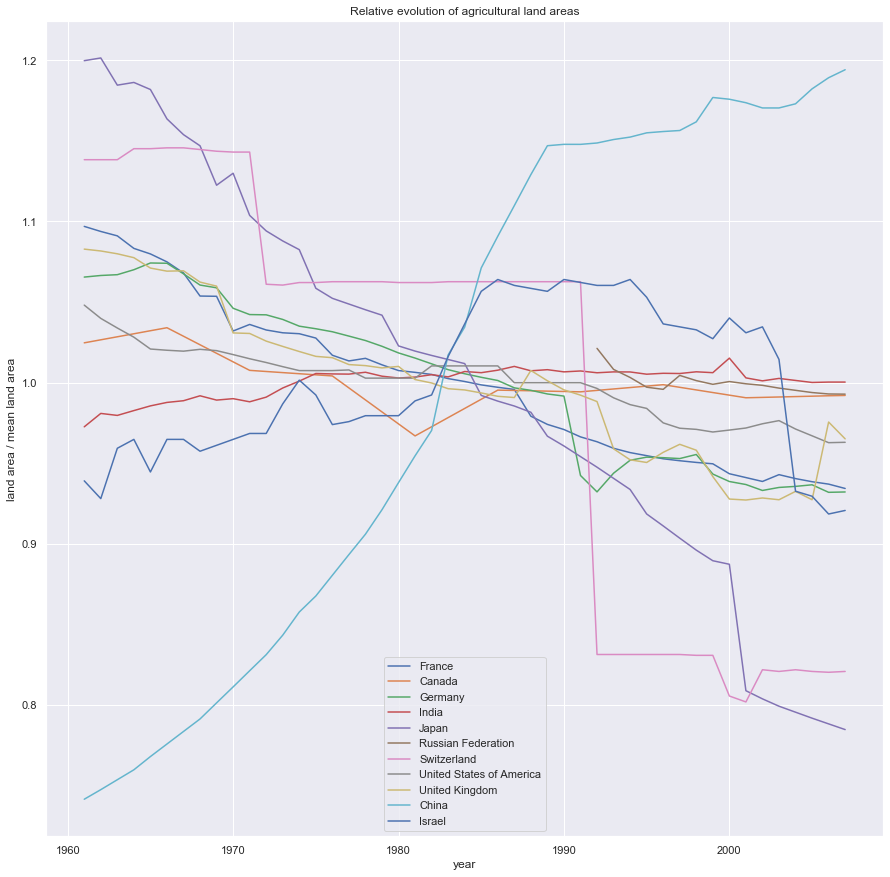

In [30]:
# let's observe the temporal evolution of agricultural lands for our selected countries

def check_country(countries, DF):
    """Checks wether the countries 'countries' are in the dataframe.series DF"""
    for country in countries:
        if country not in DF.unique():
            print('Country', country, 'is missing!')
        
check_country(countries, dataLands['country_or_area'])

# reduce subset to selected countries
rdataLands = dataLands.loc[dataLands['country_or_area'].isin(countries)]

# groupe by country
grdataLands = rdataLands.groupby('country_or_area')

plt.figure(figsize=(15,15))
for country in countries:
    # we normalize the total land area by devinding by its mean
    sns.lineplot(x=grdataLands.get_group(country).year, y=grdataLands.get_group(country).value/np.mean(grdataLands.get_group(country).value), label=country)
    
plt.ylabel('land area / mean land area')
plt.title('Relative evolution of agricultural land areas');

We observe an overall downward trend the agricultutral land areas except for a few countries (India and China). However, we also notice an anomally with Russia that must be investigated: no data is present before 1991.

After some research we found out that the dissolution of the Soviet Union (USSR) took place on 26 December 1991, creating the country Russia. We must correct our data:

In [31]:
display(dataLands[dataLands['country_or_area'] == 'USSR'].head(3))

# we don't really care about USSR, therefore, we rename it to Russia and subtract (USSR_land_1991 - Russia_land_1992) from its values
to_subtract = dataLands[(dataLands['country_or_area'] == 'USSR') & (dataLands['year'] == 1991)].value.values - dataLands[(dataLands['country_or_area'] == 'Russian Federation') & (dataLands['year'] == 1992)].value.values
# append rdataLands
for year,value in zip(dataLands[dataLands['country_or_area'] == 'USSR'].year.values, dataLands[dataLands['country_or_area'] == 'USSR'].value.values):
    rdataLands = rdataLands.append({'country_or_area':'Russian Federation', 'year':year, 'value':value - to_subtract[0]}, ignore_index=True)

,country_or_area,element_code,element,year,unit,value,value_footnotes,category
10512,USSR,11,Area,1991.0,1000 Ha,555420.0,F,agricultural_area
10513,USSR,11,Area,1990.0,1000 Ha,556220.0,I,agricultural_area
10514,USSR,11,Area,1989.0,1000 Ha,556930.0,I,agricultural_area


Text(0.5, 1.0, 'Relative evolution of agricultural land area')

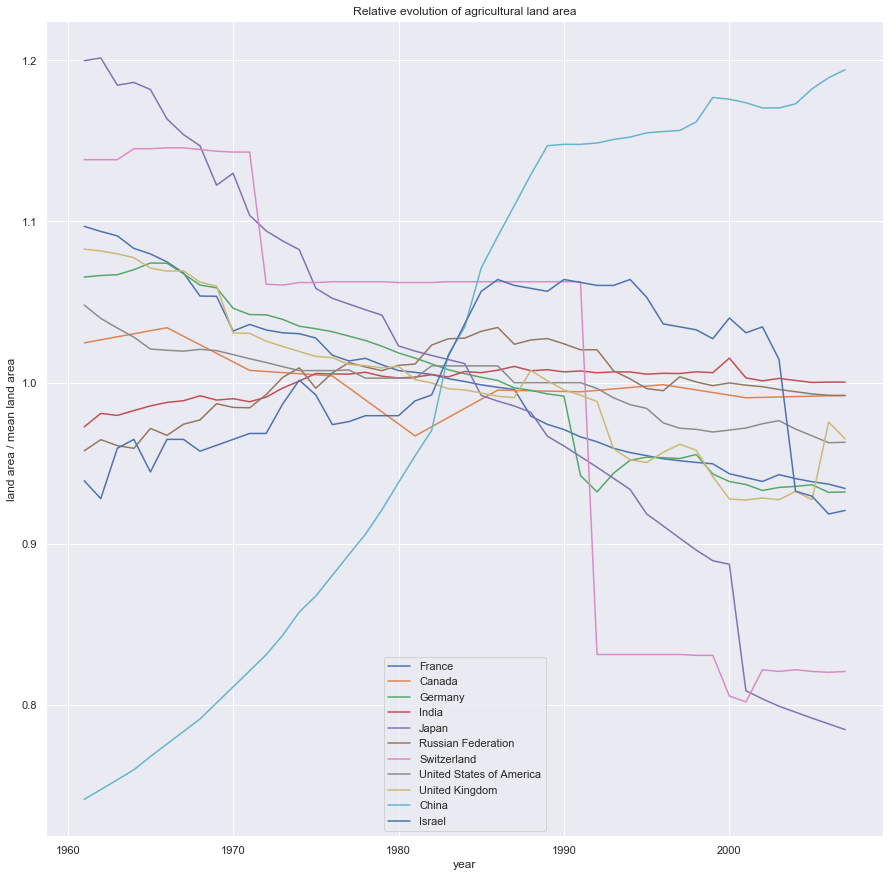

In [32]:
# check the graph again
# groupe by country
grdataLands = rdataLands.groupby('country_or_area')

plt.figure(figsize=(15,15))
for country in countries:
    # we normalize the total land area by devinding by its mean
    sns.lineplot(x=grdataLands.get_group(country).year, y=grdataLands.get_group(country).value/np.mean(grdataLands.get_group(country).value), label=country)
    
plt.ylabel('land area / mean land area')
plt.title('Relative evolution of agricultural land area')

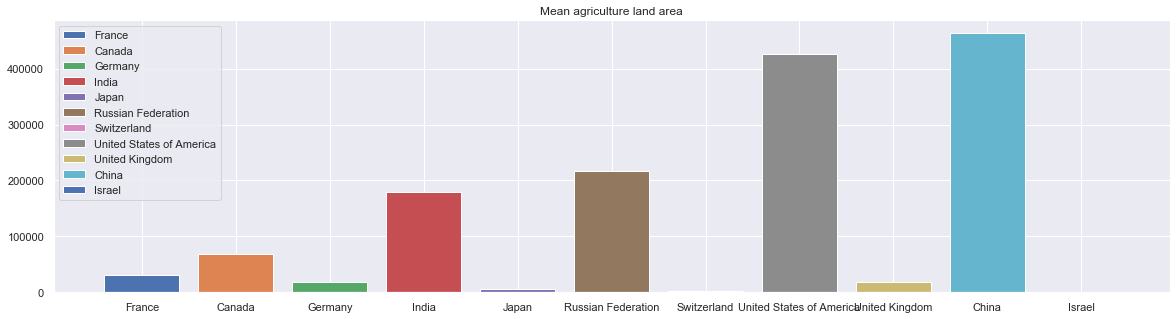

In [33]:
plt.figure(figsize=(20,5))
for country in countries:
    plt.bar(x=country, height=np.mean(grdataLands.get_group(country).value), label = country)
plt.legend()
plt.title('Mean agriculture land area');

In [34]:
rdataLands.to_pickle('dataLand.pkl')

In [35]:
# Soil erosion data
dataSoil = pd.read_csv('data/current_FAO/raw_files/Environment_Soil_E_All_Data.csv', encoding = "ISO-8859-1")
#display(dataSoil.head())

# check for our countries
print(check_country(countries, dataSoil['Country']))

# reduce to selected countries
rdataSoil = dataSoil.loc[dataSoil['Country'].isin(countries)]
rdataSoil.head()

None


,CountryCode,Country,ItemCode,Item,ElementGroup,ElementCode,Element,Year,Unit,Value,Flag
91,33,Canada,6709,Soil,7219,7219,Average soil erosion expressed in GLASOD erosi...,1991,degrees,0.44,NaN
92,33,Canada,6709,Soil,7220,7220,Average land degradation in GLASOD erosion degree,1991,degrees,0.21,NaN
93,33,Canada,6709,Soil,7221,7221,Average carbon content in the topsoil as a % i...,2008,%,4.28,NaN
114,351,China,6709,Soil,7219,7219,Average soil erosion expressed in GLASOD erosi...,1991,degrees,0.49,NaN
115,351,China,6709,Soil,7220,7220,Average land degradation in GLASOD erosion degree,1991,degrees,7.87,NaN


Except the carbon content all the other data (erosion and lan degredation) haave only 1 measure in 1991 for each country.

In [36]:
dataSoil.to_pickle('dataSoil.pkl')

## **New Data**
In order to answer the question at the beginning we need to search for and acquire some new data:

### Life expectancy at birth for both sexes combined (years):
http://data.un.org/Data.aspx?d=PopDiv&f=variableID%3a68

In [37]:
lifeExp_df = pd.read_csv('data/life_expectancy.csv')
lifeExp_df.head(3)

,Country or Area,Year(s),Variant,Value
0,Afghanistan,2095-2100,Medium,78.25
1,Afghanistan,2090-2095,Medium,77.56
2,Afghanistan,2085-2090,Medium,76.88


In [38]:
# rename columns for consistency
lifeExp_df.rename(columns={'Country or Area': 'country_or_area', 'Year(s)': 'years', 'Variant': 'variant', 'Value': 'value'}, inplace= True)

# Check our list
print(check_country(countries, lifeExp_df['country_or_area']))

# reduce to our selected countries
rlifeExp_df = lifeExp_df.loc[lifeExp_df['country_or_area'].isin(countries)]

# do we have the same problem as before with russia ?
rlifeExp_df[rlifeExp_df['country_or_area']=='Russian Federation'].tail()

None


,country_or_area,years,variant,value
6385,Russian Federation,1970-1975,Medium,68.31
6386,Russian Federation,1965-1970,Medium,68.47
6387,Russian Federation,1960-1965,Medium,67.88
6388,Russian Federation,1955-1960,Medium,64.80
6389,Russian Federation,1950-1955,Medium,58.52


Fortunately we don't have the above problem with Russia in this dataset. We observe that 'Years' is a contains 5 years long periods, thus we transform it and erase the second year (-19**). 

In [39]:
# clean column year
rlifeExp_df['year'] = rlifeExp_df['years'].str.split('-', expand=True).iloc[:,0].astype('int')
rlifeExp_df.drop(columns='years', inplace= True)
rlifeExp_df = rlifeExp_df[rlifeExp_df['year'] < 2019] # we are not interested in predictions

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Applications/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


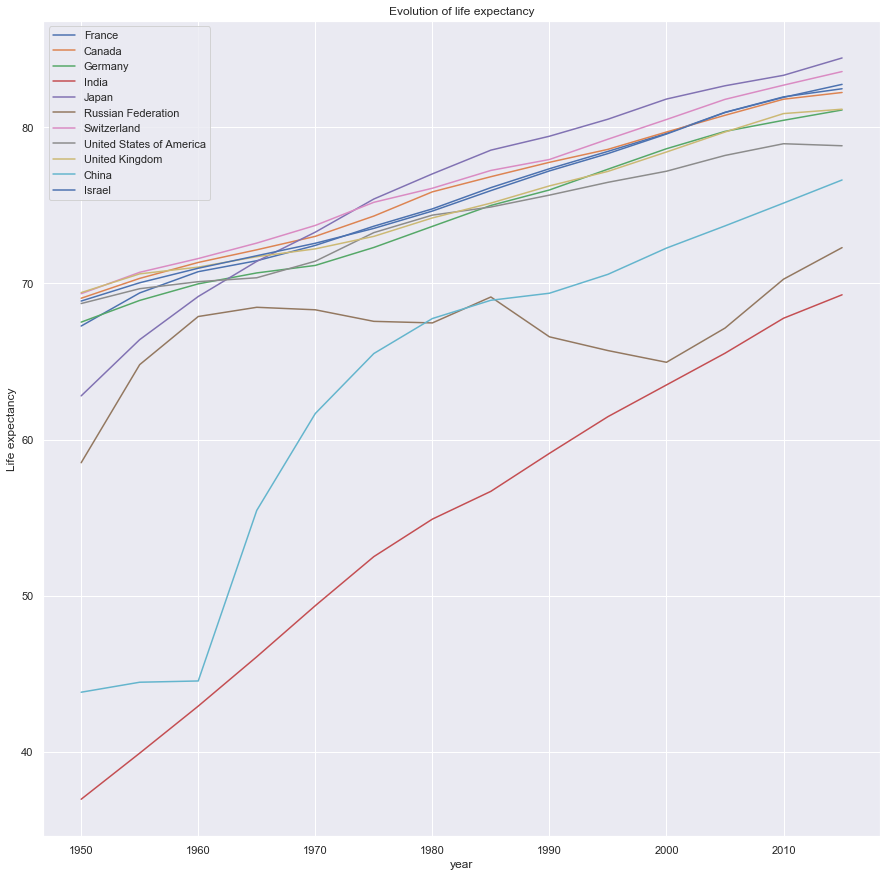

In [40]:
# simple observations
# groupe by country
grlifeExp_df = rlifeExp_df.groupby('country_or_area')

plt.figure(figsize=(15,15))
for country in countries:
    sns.lineplot(x=grlifeExp_df.get_group(country).year, y=grlifeExp_df.get_group(country).value, label=country)
    
plt.ylabel('Life expectancy')
plt.title('Evolution of life expectancy');

We see that india and china had a big evolution from the 1960s. However, China is the only country that also had a similar evolution in its agricultural lands.

In [41]:
rlifeExp_df.to_pickle('lifeExp.pkl')

### Value added by industries at current prices (ISIC Rev. 3)

We were unable to download all the data from the below website, therefore, we reduced the industries to agriculture.

http://data.un.org/Data.aspx?d=SNA&f=group_code%3a201

In [42]:
valueAdded_df = pd.read_csv('data/value_added.csv', low_memory=False)
valueAdded_df = valueAdded_df.dropna(subset=['Value'])
valueAdded_df.head(3)

,Country or Area,SNA93 Table Code,Sub Group,Item,SNA93 Item Code,Year,Series,Currency,SNA System,Fiscal Year Type,Value,Value Footnotes
0,Afghanistan,2.1,Industries,"Agriculture, hunting, forestry; fishing",A+B,2018.0,100.0,Afghanis,1993.0,Fiscal year beginning 21 March,3.024495e+11,NaN
1,Afghanistan,2.1,Industries,"Agriculture, hunting, forestry; fishing",A+B,2017.0,100.0,Afghanis,1993.0,Fiscal year beginning 21 March,3.462690e+11,NaN
2,Afghanistan,2.1,Industries,"Agriculture, hunting, forestry; fishing",A+B,2016.0,100.0,Afghanis,1993.0,Fiscal year beginning 21 March,3.165100e+11,NaN


In [43]:
# rename columns for consistency
valueAdded_df.rename(columns={'Country or Area': 'country_or_area', 'Year': 'year', 'Value': 'value'}, inplace= True)

# Check our list
print(check_country(countries, valueAdded_df['country_or_area']))

Country United States of America is missing!
None


In [44]:
# print all countries
print(valueAdded_df['country_or_area'].unique().tolist())

['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola', 'Anguilla', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bermuda', 'Bhutan', 'Bolivia (Plurinational State of)', 'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'British Virgin Islands', 'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada', 'Cayman Islands', 'Central African Republic', 'Chad', 'Chile', 'China', 'China, Hong Kong Special Administrative Region', 'Colombia', 'Comoros', 'Congo', 'Cook Islands', 'Costa Rica', "Côte d'Ivoire", 'Croatia', 'Cuba', 'Curaçao', 'Cyprus', 'Czechia', 'Democratic Republic of the Congo', 'Democratic Yemen [former]', 'Denmark', 'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Estonia', 'Eswatini', 'Ethiopia [from 1993]', 'Ethiopia [up to 1993]', 'Faro

In [45]:
# Correct for united states
valueAdded_df.replace(to_replace='United States', value='United States of America', inplace= True)

# reduce to our selected countries
rvalueAdded_df = valueAdded_df.loc[valueAdded_df['country_or_area'].isin(countries)]

# do we have the same problem as before with russia ?
rvalueAdded_df[rvalueAdded_df['country_or_area']=='Russian Federation'].tail()

,country_or_area,SNA93 Table Code,Sub Group,Item,SNA93 Item Code,year,Series,Currency,SNA System,Fiscal Year Type,value,Value Footnotes
16080,Russian Federation,2.1,Industries,"Agriculture, hunting, forestry",A,1991.0,100.0,Russian ruble,1993.0,Western calendar year,1.926000e+11,NaN
16081,Russian Federation,2.1,Industries,"Agriculture, hunting and related service activ...",01,1991.0,100.0,Russian ruble,1993.0,Western calendar year,1.911000e+11,NaN
16082,Russian Federation,2.1,Industries,"Agriculture, hunting, forestry; fishing",A+B,1990.0,100.0,Russian ruble,1993.0,Western calendar year,9.960000e+10,NaN
16083,Russian Federation,2.1,Industries,"Agriculture, hunting, forestry",A,1990.0,100.0,Russian ruble,1993.0,Western calendar year,9.960000e+10,NaN
16084,Russian Federation,2.1,Industries,"Agriculture, hunting and related service activ...",01,1990.0,100.0,Russian ruble,1993.0,Western calendar year,9.910000e+10,NaN


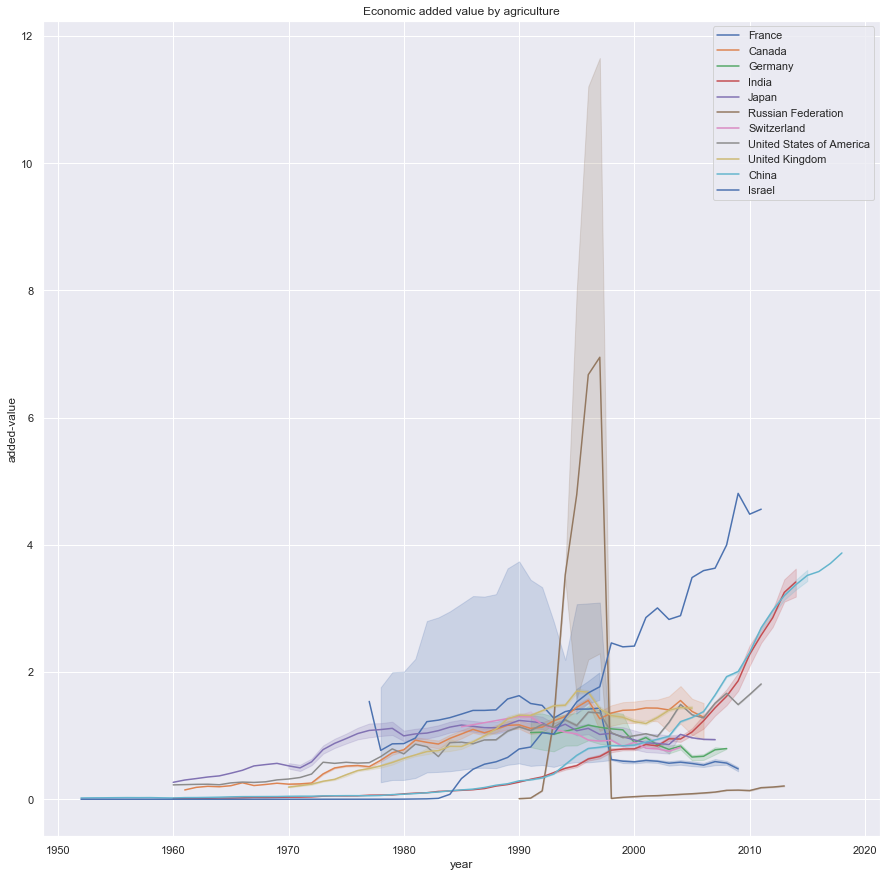

In [46]:
# simple observations
# groupe by country
gvalueAdded_df = valueAdded_df.groupby('country_or_area')

plt.figure(figsize=(15,15))
for country in countries:
    # plot  and normalize by mean
    sns.lineplot(x=gvalueAdded_df.get_group(country).year, y=gvalueAdded_df.get_group(country).value/np.mean(gvalueAdded_df.get_group(country).value), label=country)
    
plt.ylabel('added-value')
plt.title('Economic added value by agriculture');

We see a strange peek with Russia that will have to be investigated for the final milestone. Russia's data starts from 1990 so we might have the same problem as before, but USSR is absent from the data...

In [47]:
valueAdded_df.to_pickle('valueAdded.pkl')

### Employment by sex and economic activity

https://www.ilo.org/shinyapps/bulkexplorer5/?lang=en&segment=indicator&id=EMP_TEMP_SEX_ECO_NB_A

In [48]:
employment_df = pd.read_csv('data/Employment.csv')
display(employment_df.head(3))
employment_df = employment_df.drop(columns=['obs_status.label', 'note_classif.label', 'note_indicator.label'])   # drop useless columns

,ref_area.label,indicator.label,source.label,sex.label,classif1.label,time,obs_value,obs_status.label,note_classif.label,note_indicator.label,note_source.label
0,Aruba,Employment by sex and economic activity (thous...,ABW - LFS - Labour force survey,Sex: Total,Economic activity (ISIC-Rev.3.1): Total,1994,35.94,NaN,NaN,NaN,Data reference period: October
1,Aruba,Employment by sex and economic activity (thous...,ABW - LFS - Labour force survey,Sex: Total,Economic activity (ISIC-Rev.3.1): A. Agricultu...,1994,0.03,NaN,NaN,NaN,Data reference period: October
2,Aruba,Employment by sex and economic activity (thous...,ABW - LFS - Labour force survey,Sex: Total,Economic activity (ISIC-Rev.3.1): B. Fishing,1994,0.01,NaN,NaN,NaN,Data reference period: October


In [49]:
# rename columns for consistency
employment_df.rename(columns={'ref_area.label': 'country_or_area', 'time': 'year', 'obs_value': 'value', 'classif1.label': 'activity'}, inplace= True)

# Check our list
print(check_country(countries, employment_df['country_or_area']))

# Correct for united states
employment_df.replace(to_replace='United States', value='United States of America', inplace= True)

# reduce to our selected countries
remployment_df = employment_df.loc[employment_df['country_or_area'].isin(countries)]

# USSR isn't present: no problem
np.sort(employment_df['country_or_area'].unique())[-20:]

Country United States of America is missing!
None


array(['Togo', 'Tonga', 'Trinidad and Tobago', 'Tunisia', 'Turkey',
       'Turks and Caicos Islands', 'Tuvalu', 'Uganda', 'Ukraine',
       'United Arab Emirates', 'United Kingdom',
       'United States of America', 'Uruguay', 'Uzbekistan', 'Vanuatu',
       'Venezuela, Bolivarian Republic of', 'Viet Nam', 'Yemen', 'Zambia',
       'Zimbabwe'], dtype=object)

In [50]:
# do a sub selection of only agricultural related economic activites
remployment_df = remployment_df[remployment_df['activity'].str.contains('Agriculture')]

In [51]:
# extra cleaning
remployment_df.drop(columns=['indicator.label', 'source.label', 'note_source.label'], inplace= True)   # drop useless columns
remployment_df.replace({'Sex: Male': 'male', 'Sex: Female': 'female', 'Sex: Total': 'total'}, inplace= True)

In [52]:
remployment_df.head()

,country_or_area,sex.label,activity,year,value
48061,Canada,total,Economic activity (ISIC-Rev.2): 1. Agriculture...,1969,616.0
48071,Canada,male,Economic activity (ISIC-Rev.2): 1. Agriculture...,1969,543.0
48081,Canada,female,Economic activity (ISIC-Rev.2): 1. Agriculture...,1969,73.0
48091,Canada,total,Economic activity (Aggregate): Agriculture,1969,616.0
48098,Canada,male,Economic activity (Aggregate): Agriculture,1969,543.0


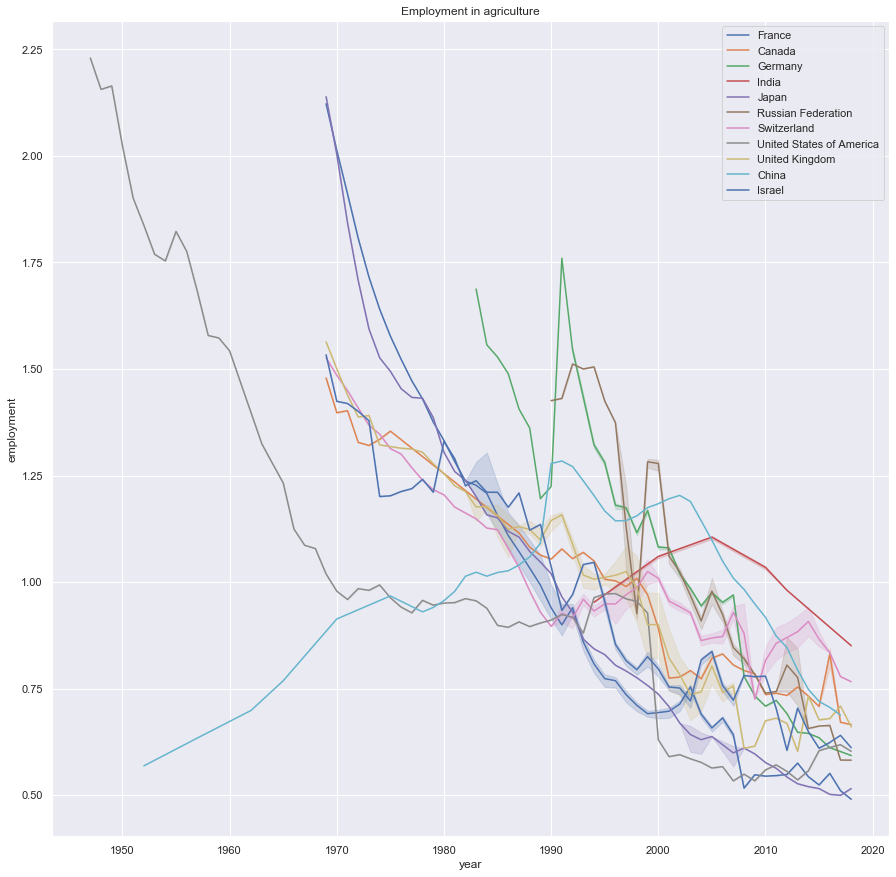

In [53]:
# simple observations
# groupe by country
gremployment_df = remployment_df[remployment_df['sex.label'] == 'total'].groupby('country_or_area')

plt.figure(figsize=(15,15))
for country in countries:
    # plot and normalize by mean
    sns.lineplot(x=gremployment_df.get_group(country).year, y=gremployment_df.get_group(country).value/np.mean(gremployment_df.get_group(country).value), label=country)
    
plt.ylabel('employment')
plt.title('Employment in agriculture');

We see an overall downtrend in the agricultural employments.Let's compare the mean employment of the countries:

Text(0.5, 1.0, 'Mean Employment in agriculture')

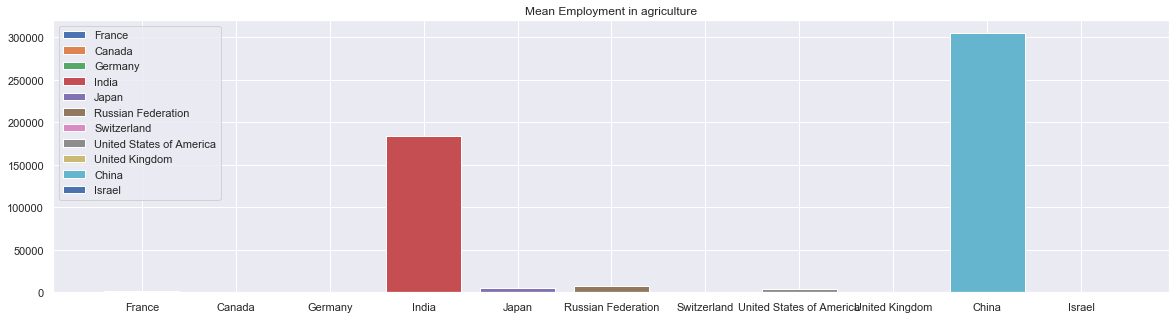

In [54]:
plt.figure(figsize=(20,5))
for country in countries:
    plt.bar(x=country, height=np.mean(gremployment_df.get_group(country).value), label = country)
plt.legend()
plt.title('Mean Employment in agriculture')

In order to have a meaningfull comparison the above values should be devided by the total population, but in an absolute comparison we can see employment in agricultural sectors is rather big in China and India.

Compared to the bar chart of agricultural lands above, we notice United States for example that has a pretty vast agricultural land area but has very little employments in agriculture in comparison. 

In [55]:
remployment_df.to_pickle('employment.pkl')

### Non fatal occupational injuries per 100'000 workers by economic activity

We found it hard to find reliable data for the 'quality of life' which could be subjective and not necessarily related to agriculture. Thus, we found the below dataset which describes the amount of non fatal injuries per economic activity, which we found interessting as a way to asses the social quality and safety of agriculture.

https://www.ilo.org/shinyapps/bulkexplorer32/?lang=en&segment=indicator&id=INJ_NFTL_ECO_RT_A

In [56]:
nonFatalInjuries_df = pd.read_csv('data/non_fatal_injuries.csv')

#look at some useless columns before droping them
print(nonFatalInjuries_df.obs_status.unique())
print(nonFatalInjuries_df.note_classif.unique().tolist())
nonFatalInjuries_df = nonFatalInjuries_df.drop(columns=['obs_status', 'obs_status.label', 'note_classif', 'note_classif.label', 'note_source', 'note_source.label', 'indicator.label', 'note_indicator', 'source', 'source.label'])   # drop useless columns
nonFatalInjuries_df.head(3)

[nan 'U' 'P' 'B']
[nan, 'C5:1595', 'C5:2962', 'C5:1023', 'C5:1019', 'C5:1015_C5:1022', 'C5:1989', 'C5:2048', 'C5:2029', 'C5:4107']


,ref_area,ref_area.label,indicator,classif1,classif1.label,time,obs_value,note_indicator.label
0,ANT,Netherlands Antilles,INJ_NFTL_ECO_RT,ECO_ISIC3_TOTAL,Economic activity (ISIC-Rev.3.1): Total,1994,2595.0,Coverage of occupational injuries: Reported in...
1,ANT,Netherlands Antilles,INJ_NFTL_ECO_RT,ECO_AGGREGATE_TOTAL,Economic activity (Aggregate): Total,1994,2595.0,Coverage of occupational injuries: Reported in...
2,ANT,Netherlands Antilles,INJ_NFTL_ECO_RT,ECO_ISIC3_TOTAL,Economic activity (ISIC-Rev.3.1): Total,1995,2959.0,Coverage of occupational injuries: Reported in...


In [57]:
# rename columns for consistency
nonFatalInjuries_df.rename(columns={'ref_area.label': 'country_or_area', 'time': 'year', 'obs_value': 'value', 'classif1.label': 'activity'}, inplace= True)

# Check our list
print(check_country(countries, nonFatalInjuries_df['country_or_area']))

Country Canada is missing!
Country United States of America is missing!
Country China is missing!
None


In [58]:
print(np.sort(nonFatalInjuries_df['country_or_area'].unique()).tolist())

['Algeria', 'Argentina', 'Armenia', 'Australia', 'Austria', 'Azerbaijan', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bolivia', 'Botswana', 'Brazil', 'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Cape Verde', 'Chad', 'Chile', 'Colombia', 'Comoros', 'Costa Rica', 'Croatia', 'Cuba', 'Cyprus', 'Czechia', 'Denmark', 'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador', 'Estonia', 'Finland', 'France', 'French Guiana', 'Gabon', 'Germany', 'Greece', 'Guadeloupe', 'Guam', 'Guatemala', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Hong Kong, China', 'Hungary', 'Iceland', 'India', 'Indonesia', 'Ireland', 'Isle of Man', 'Israel', 'Italy', 'Jamaica', 'Japan', 'Jordan', 'Kazakhstan', 'Korea, Republic of', 'Kyrgyzstan', 'Latvia', 'Lithuania', 'Luxembourg', 'Macau, China', 'Malawi', 'Malaysia', 'Mali', 'Malta', 'Mauritius', 'Mexico', 'Moldova, Republic of', 'Mongolia', 'Morocco', 'Myanmar', 'Namibia', 'Netherlands', 'Netherlands Antilles', 'New Caledonia', 'New Zeala

In [59]:
# Problem: Canada is REALLY missing...

# Correct for united states
nonFatalInjuries_df.replace(to_replace='United States', value='United States of America', inplace= True)

# Only keep activities related to agriculture
rnonFatalInjuries_df = nonFatalInjuries_df[nonFatalInjuries_df['activity'].str.contains('Agriculture')]

# There are several regions (cities) of China present in the data set but no China as a whole.
# As our value of interest is a rate, we can take the mean of the latter rates for China as a whole
china_injuries = rnonFatalInjuries_df[nonFatalInjuries_df['country_or_area'].str.contains('China')].reset_index()
print(china_injuries['country_or_area'].unique())    # different chinese cities present

['Macau, China' 'Taiwan, China']


/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


In [60]:
china_injuries.head()

,index,ref_area,country_or_area,indicator,classif1,activity,year,value,note_indicator.label
0,14446,MAC,"Macau, China",INJ_NFTL_ECO_RT,ECO_ISIC3_A,Economic activity (ISIC-Rev.3.1): A. Agricultu...,2006,0.0,Coverage of occupational injuries: Reported in...
1,22992,TWN,"Taiwan, China",INJ_NFTL_ECO_RT,ECO_ISIC2_1,Economic activity (ISIC-Rev.2): 1. Agriculture...,1988,236.0,Coverage of occupational injuries: Reported in...
2,23003,TWN,"Taiwan, China",INJ_NFTL_ECO_RT,ECO_ISIC2_1,Economic activity (ISIC-Rev.2): 1. Agriculture...,1989,259.1,Coverage of occupational injuries: Reported in...
3,23014,TWN,"Taiwan, China",INJ_NFTL_ECO_RT,ECO_ISIC2_1,Economic activity (ISIC-Rev.2): 1. Agriculture...,1990,233.9,Coverage of occupational injuries: Reported in...
4,23025,TWN,"Taiwan, China",INJ_NFTL_ECO_RT,ECO_ISIC2_1,Economic activity (ISIC-Rev.2): 1. Agriculture...,1991,219.3,Coverage of occupational injuries: Reported in...


There is only one entry for Macau and its value is 0. So we drop it and represent China by Taiwan.

In [61]:
china_injuries.drop(index= 0, axis= 0, inplace= True)
china_injuries.replace('Taiwan, China', 'China', inplace= True)

# append with China data
rnonFatalInjuries_df = rnonFatalInjuries_df.append(china_injuries, sort=False, ignore_index= True)

# reduce to our selected countries
rnonFatalInjuries_df = rnonFatalInjuries_df.loc[rnonFatalInjuries_df['country_or_area'].isin(countries)]

# recheck countries
check_country(countries, rnonFatalInjuries_df['country_or_area'])

Country Canada is missing!
Country Japan is missing!


We now see that also Japan is missing but that is because Japan hasn't Agriculture in its activity column.

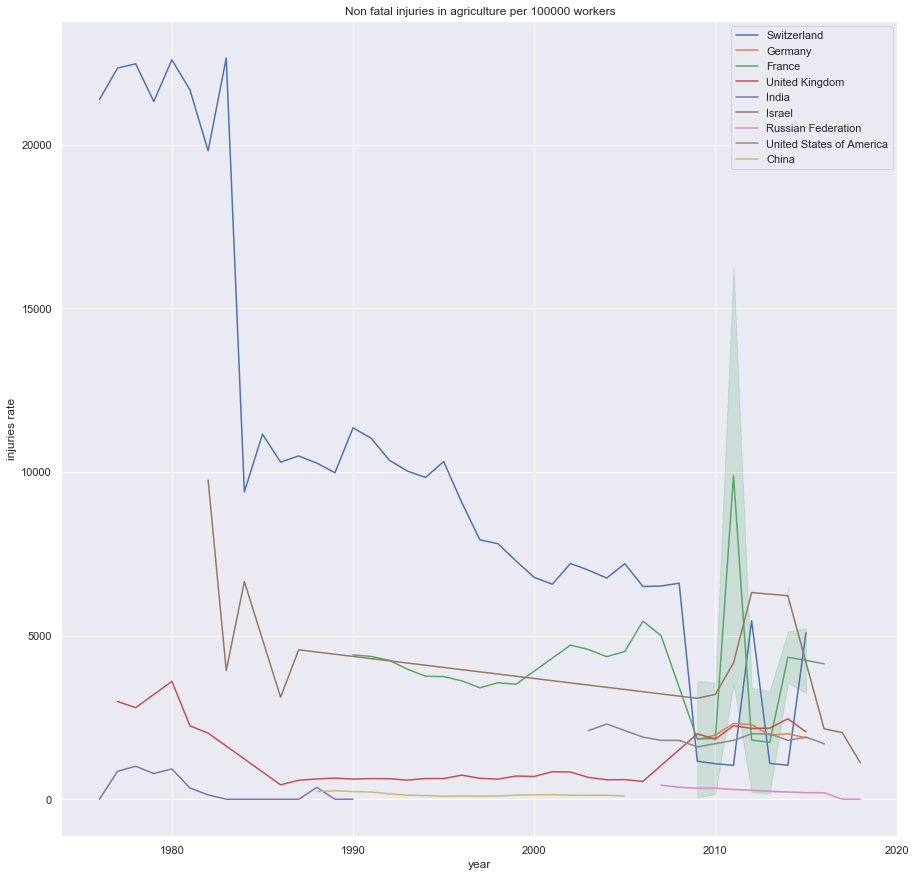

In [62]:
# simple observations
# groupe by country
grnonFatalInjuries_df = rnonFatalInjuries_df.groupby('country_or_area')

plt.figure(figsize=(15,15))
for country in rnonFatalInjuries_df['country_or_area'].unique():
    # plot and normalize by mean
    sns.lineplot(x=grnonFatalInjuries_df.get_group(country).year, y=grnonFatalInjuries_df.get_group(country).value, label=country)
    
plt.ylabel('injuries rate')
plt.title('Non fatal injuries in agriculture per 100000 workers');

We notice that the data for some countries (China, Russia, India, US, Germany) doesn't cover the entire year range. We also observe unusually high values for Switzerland, which makes us question the sanity of the data. This data in its current form, probably might not be usable for further analysis...

In [63]:
rnonFatalInjuries_df.to_pickle('nonFatalInjuries.pkl')

# **Question 3 - Analysis**

Is it possible to rank some patterns of land usage with social and environmental factors such as employment, life satisfaction (if data are presents), income inequalities (if data are presents), emissions and finally soil quality and sustainability?

As we saw in the data cleaning nootebook, it is messy and difficult to do analysis for more than 5 countries. Therefore, we reduce our subset to the five following countires: China, India, USA, UK, Switzerland

We chose these countries because we were interested in them and thought that we might find interesting results as they are somehow special countries:

- China has had a massive growth and is now world leading.
- India is a big country with a very traditional soul and also huge growth in the recent years.
- USA has always been a world power however it has not been growing as fast as the above countires in the recent years.
- UK has been a leader in Europe and has had several interesting events in the recent years such as Brexit.
- Switzerland has always been rather stable and it's the country we live in :)

In [64]:
countries = ['China', 'India', 'United States of America', 'United Kingdom', 'Switzerland']

In [65]:
# read cleaned data:
dataLands         = pd.read_pickle('data/dataLand.pkl')
dataSoil          = pd.read_pickle('data/dataSoil.pkl')
employment        = pd.read_pickle('data/employment.pkl')
lifeExp           = pd.read_pickle('data/lifeExp.pkl')
nonFatatlInjuries = pd.read_pickle('data/nonFatalInjuries.pkl')
addedValue        = pd.read_pickle('data/valueAdded.pkl')

In [66]:
# reduce the data to selected countries
dataLands  = dataLands.loc[dataLands['country_or_area'].isin(countries)].reset_index(drop=True)
dataSoil   = dataSoil.loc[dataSoil['Country'].isin(countries)].reset_index(drop=True)
employment = employment.loc[employment['country_or_area'].isin(countries)].reset_index(drop=True)
lifeExp    = lifeExp.loc[lifeExp['country_or_area'].isin(countries)].reset_index(drop=True)
injuries   = nonFatatlInjuries.loc[nonFatatlInjuries['country_or_area'].isin(countries)].reset_index(drop=True)
addedValue = addedValue.loc[addedValue['country_or_area'].isin(countries)].reset_index(drop=True)

## Population Data

We also acquired some new data on world population via the link below. We selected our list of countries directly on the website as it's simpler.

https://databank.worldbank.org/reports.aspx?source=2&series=SP.POP.TOTL&country=#

In [67]:
population = pd.read_csv('data/population.csv').dropna()

In [68]:
population.drop(columns= ['Country Code', 'Series Code', 'Series Name'], inplace=True)
population

,Country Name,1960 [YR1960],1961 [YR1961],1962 [YR1962],1963 [YR1963],1964 [YR1964],1965 [YR1965],1966 [YR1966],1967 [YR1967],1968 [YR1968],...,2009 [YR2009],2010 [YR2010],2011 [YR2011],2012 [YR2012],2013 [YR2013],2014 [YR2014],2015 [YR2015],2016 [YR2016],2017 [YR2017],2018 [YR2018]
0,China,667070000.0,660330000.0,665770000.0,682335000.0,698355000.0,715185000.0,735400000.0,754550000.0,774510000.0,...,1.331260e+09,1.337705e+09,1.344130e+09,1.350695e+09,1.357380e+09,1.364270e+09,1.371220e+09,1.378665e+09,1.386395e+09,1.392730e+09
1,Switzerland,5327827.0,5434294.0,5573815.0,5694247.0,5789228.0,5856472.0,5918002.0,5991785.0,6067714.0,...,7.743831e+06,7.824909e+06,7.912398e+06,7.996861e+06,8.089346e+06,8.188649e+06,8.282396e+06,8.373338e+06,8.451840e+06,8.516543e+06
2,United States,180671000.0,183691000.0,186538000.0,189242000.0,191889000.0,194303000.0,196560000.0,198712000.0,200706000.0,...,3.067715e+08,3.093261e+08,3.115800e+08,3.138742e+08,3.160577e+08,3.183864e+08,3.207427e+08,3.230713e+08,3.251471e+08,3.271674e+08
3,United Kingdom,52400000.0,52800000.0,53250000.0,53650000.0,54000000.0,54348050.0,54648500.0,54943600.0,55211700.0,...,6.227627e+07,6.276636e+07,6.325892e+07,6.370030e+07,6.412823e+07,6.461316e+07,6.512886e+07,6.559556e+07,6.605886e+07,6.648899e+07
4,India,450547679.0,459642165.0,469077190.0,478825608.0,488848135.0,499123324.0,509631500.0,520400576.0,531513824.0,...,1.217726e+09,1.234281e+09,1.250289e+09,1.265783e+09,1.280846e+09,1.295604e+09,1.310152e+09,1.324510e+09,1.338659e+09,1.352617e+09


In [69]:
# the columns above are ugly: we create a dictionary to replace them with values afterwards
col_years = dict((col,year) for col,year in zip(population.columns[1:], np.arange(1960,2019)))

In [70]:
population = population.melt(id_vars=['Country Name'], var_name= 'year', value_name= 'value')
population.replace(col_years, inplace=True)

# rename USA
population.replace({'United States':'United States of America'}, inplace=True)
population.head(6)

,Country Name,year,value
0,China,1960,667070000.0
1,Switzerland,1960,5327827.0
2,United States of America,1960,180671000.0
3,United Kingdom,1960,52400000.0
4,India,1960,450547679.0
5,China,1961,660330000.0


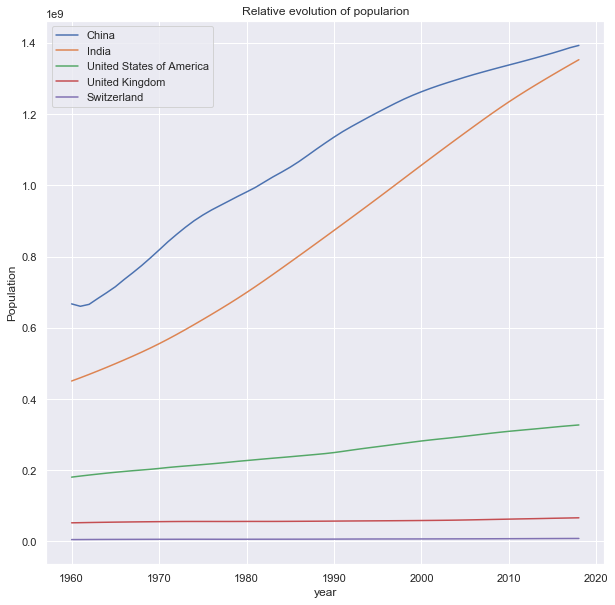

In [71]:
grPopulation = population.groupby('Country Name')

plt.figure(figsize=(10,10))
for country in countries:
    
    sns.lineplot(x=grPopulation.get_group(country).year, y=grPopulation.get_group(country).value, label=country)
    
plt.ylabel('Population')
plt.title('Relative evolution of popularion');

We can see that the population of India and China grows really fast compared to USA. The population of UK and Switzerland are pretty satble.

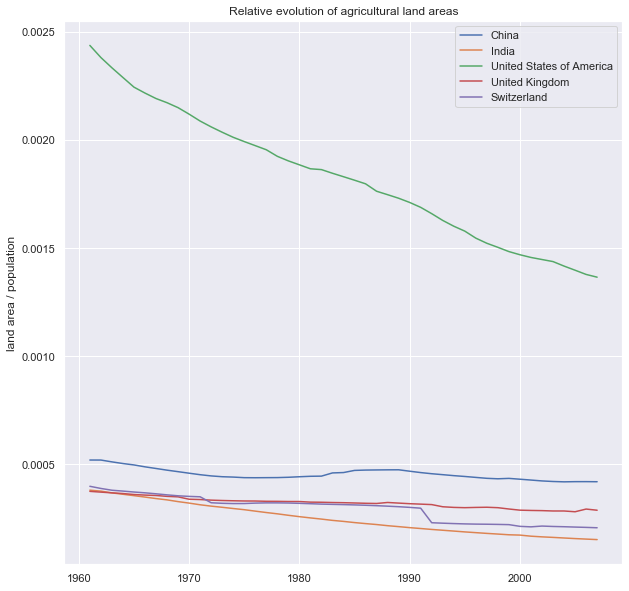

In [72]:
# groupe by country
grdataLands = dataLands.groupby('country_or_area')

plt.figure(figsize=(10,10))
for country in countries:
    # result list
    norm_land = []
    # we normalize the total land area by population each year
    for year in grdataLands.get_group(country).year.values:
        
        #compute Land / Population ratio for each year
        ratio = grdataLands.get_group(country)[grdataLands.get_group(country).year == year].value.values/ \
                grPopulation.get_group(country)[grPopulation.get_group(country).year == year].value.values
        
        norm_land.append([year, ratio[0]])
        
    sns.lineplot(x=[row[0] for row in norm_land], y=[row[1] for row in norm_land], label=country, estimator=None)
    
plt.ylabel('land area / population')
plt.title('Relative evolution of agricultural land areas');

We see some strange kinks in Switzerland; Let's investigate

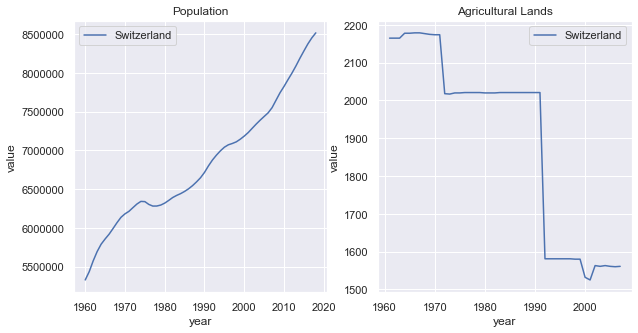

In [73]:
# Switzerland agricultural land and population
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
sns.lineplot(x=grPopulation.get_group('Switzerland').year, y=grPopulation.get_group('Switzerland').value, label='Switzerland', ax=ax[0])
ax[0].set_title('Population')
sns.lineplot(x=grdataLands.get_group('Switzerland').year, y=grdataLands.get_group('Switzerland').value, label='Switzerland', ax=ax[1])
ax[1].set_title('Agricultural Lands');

The problem comes from the Land data; According to Encyclopedia.com :"Swiss agricultural policy is highly regulated, with fixed prices and quota restrictions maintained on several products. Domestic production is encouraged by the imposition of protective customs and duties on imported goods, and by restrictions on imports. The Federal Council has the authority to fix prices of bread grains, flour, milk, and other foodstuffs. Production costs in Switzerland, as well as international exchange rates favorable to the Swiss franc, make competition with foreign products difficult. This highly protectionist system has led to excess production and mounting costs associated with the management of surpluses. The Uruguay Round and subsequent Swiss implementation of its provisions in July 1995 (along with rising costs in the agricultural sector) has forced the government to begin reforming its agricultural support system."

This could be a potential explanation for this behavior, however the kinks in the graph don't really matter for the overall analysis.

We will now investage agricultural employment for each country, comparing male and female employment. As China has only reported the total employments (no male/female separation) it doesn't figure in the first subplots.

<Figure size 720x720 with 0 Axes>

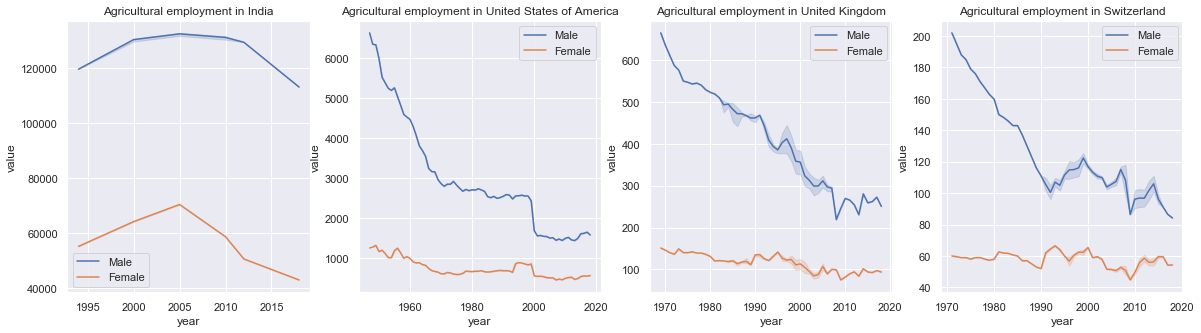

In [74]:
# groupe by country
grEmployment = employment.groupby(['country_or_area','sex.label'])

plt.figure(figsize=(10,10))
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20,5))

for i,country in enumerate(['India', 'United States of America', 'United Kingdom', 'Switzerland']):
    
    sns.lineplot(x=grEmployment.get_group((country, 'male')).year, y=grEmployment.get_group((country, 'male')).value, label='Male', ax=ax[i])
    sns.lineplot(x=grEmployment.get_group((country, 'female')).year, y=grEmployment.get_group((country, 'female')).value, label='Female', ax=ax[i])
    ax[i].set_title('Agricultural employment in '+country)

We observe several interesting facts:
- The gap between male and female employment in agriculture decreases over time for USA, UK and Switzerland but stays rather stable for India.
- Comparing males and females employment, we notice that female agricultural employment stays rather stable over time but the male employment decreases. An explanation for this observation could be the relationship of farmers of different sexes with "technology" and automatization. In fact, the major reason of the decrease in agricultural employment could be industrialization and the automatization of agriculture using technology and machines:

    - The male's labor in agriculture back in time has been gradually replaced by machines.
    - Agricultural industrialization had lower impact on females labor as they probably were not the ones harvesting the plants.
    
    
- We also notice a strange downward kink in USA's chart right before year 2000. This could be due to a big technological leap in agriculture but it is most likely due to the dot-com bubble as many people during that year converted to 'entrepreneurs' creating random websites and easiliy obtain fundings and revenue.

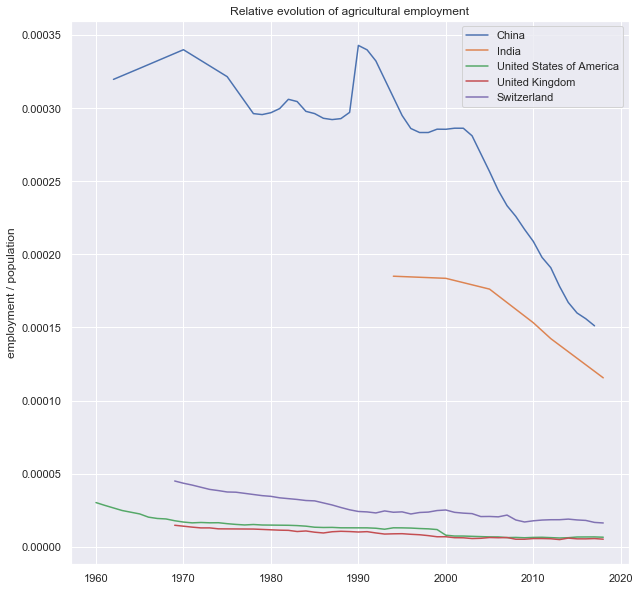

In [75]:
# total aggricultural employment
plt.figure(figsize=(10,10))
for country in countries:
    # store normalized employment in a list
    norm_employment = []
    
    # we normalize the total employment by population each year
    for year in grEmployment.get_group((country, 'total')).year.values:
        
        if year >= 1960:   # population starting year
            #compute Land / Population ratio for each year
            ratio = grEmployment.get_group((country, 'total'))[grEmployment.get_group((country, 'total')).year == year].value.values/ \
                    grPopulation.get_group(country)[grPopulation.get_group(country).year == year].value.values

            norm_employment.append([year, ratio[0]])
        
    sns.lineplot(x=[row[0] for row in norm_employment], y=[row[1] for row in norm_employment], label=country, estimator=None)
    
plt.ylabel('employment / population')
plt.title('Relative evolution of agricultural employment');

We observe that China has the highest ratio of relative agricultural employment followed by India, Switzerland, USA and UK.

### Life Expectancy

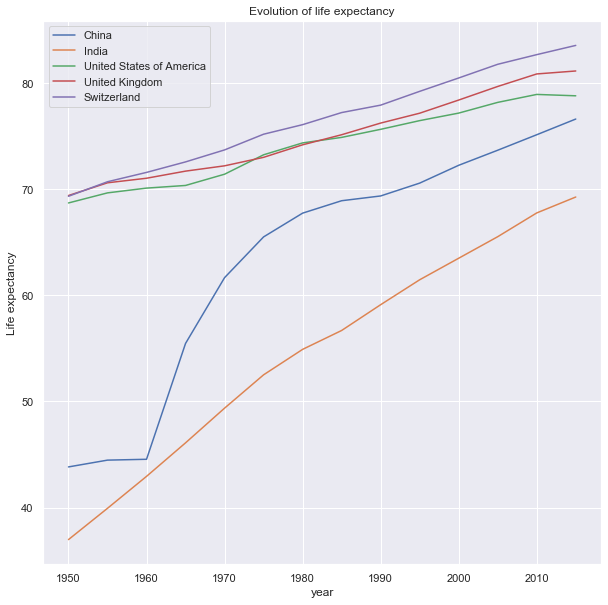

In [76]:
grLifeExp = lifeExp.groupby('country_or_area')

plt.figure(figsize=(10,10))
for country in countries:
    sns.lineplot(x=grLifeExp.get_group(country).year, y=grLifeExp.get_group(country).value, label=country)
    
plt.ylabel('Life expectancy')
plt.title('Evolution of life expectancy');

## Economic Added Value

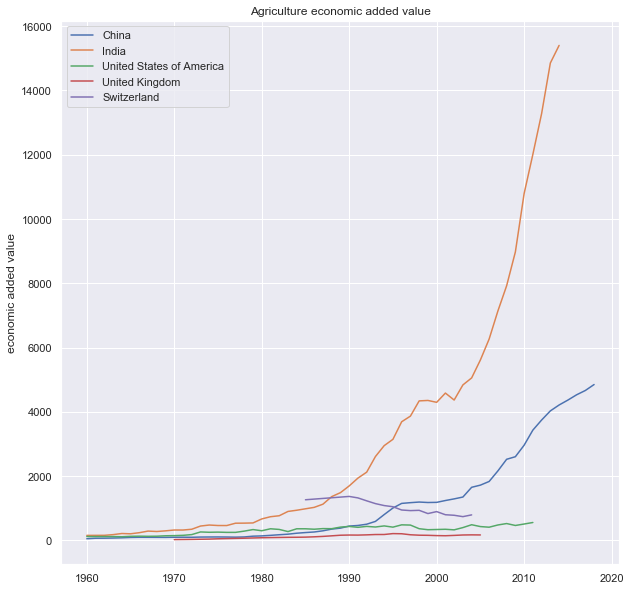

In [77]:
grAddedValue = addedValue.groupby('country_or_area')

plt.figure(figsize=(10,10))
for country in countries:
    # store normalized employment in a list
    norm_addedValue = []
    
    # we normalize the total employment by population each year
    for year in grAddedValue.get_group(country).year.values:
        
        if year >= 1960:   # population starting year
            #compute Land / Population ratio for each year
            ratio = grAddedValue.get_group(country)[grAddedValue.get_group(country).year == year].value.values/ \
                    grPopulation.get_group(country)[grPopulation.get_group(country).year == year].value.values

            norm_addedValue.append([year, ratio[0]])
        
    sns.lineplot(x=[row[0] for row in norm_addedValue], y=[row[1] for row in norm_addedValue], label=country, estimator=None)
    
plt.ylabel('economic added value')
plt.title('Agriculture economic added value');

It is interesting to notice that india has the largest economical added value via agriculture, however it has the smallest agricultural land to population ratio.

## Question 4

Is the temporal evolution of agricultural land always correlated with the temporal evolution of the quantity of fertilizers used (and waste emission) or there’s some point in time where this trend slows or reverses for some countries?

#### DATA PREPROCESSING

In [78]:
#Gettinge Merge Fertilisant df

Fertdf=pd.read_csv('data/Inputs_FertilizersNutrient_E_All_Data.csv', sep=',',engine='python')
colnames = ['Area','Item','Element','Y2002','Y2003','Y2004','Y2005','Y2006','Y2007','Y2008','Y2009','Y2010','Y2011','Y2012','Y2013',
              'Y2014','Y2015','Y2016','Y2017']
Newdf = Fertdf[colnames]
display(Newdf.head())

Newdf = Newdf[Newdf.Element=='Agricultural Use']
Newdf.columns = Newdf.columns.str.replace('Y','')
Meltdf = pd.melt(Newdf, id_vars=['Area','Item','Element'], var_name='Year', value_name='Value').copy()
Meltdf.head()

,Area,Item,Element,Y2002,Y2003,Y2004,Y2005,Y2006,Y2007,Y2008,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017
0,Afghanistan,Nutrient nitrogen N (total),Production,23414.00,16206.00,19458.00,15631.00,17636.00,16973.00,15324.00,13606.00,12022.00,17555.00,15776.00,15694.00,14416.00,14416.00,14416.00,14416.00
1,Afghanistan,Nutrient nitrogen N (total),Import Quantity,1132.46,4233.77,2905.48,4849.98,3135.99,7.00,4.68,1001.89,914.39,5411.94,1289.25,19223.36,59482.34,6659.57,82277.39,126363.30
2,Afghanistan,Nutrient nitrogen N (total),Export Quantity,22.93,32.75,23.79,14.84,308.77,602.71,896.65,452.01,7.38,0.00,0.00,13.57,27.14,0.00,22.55,5.14
3,Afghanistan,Nutrient nitrogen N (total),Agricultural Use,24523.53,20407.02,22339.69,20466.15,20463.22,16377.29,14432.03,14155.88,12929.01,22970.63,17065.25,34903.79,73872.84,21075.57,96670.85,140775.85
4,Afghanistan,Nutrient phosphate P2O5 (total),Production,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1563.00,460.00,1539.00,1541.00,1541.00,1541.00,1541.00


,Area,Item,Element,Year,Value
0,Afghanistan,Nutrient nitrogen N (total),Agricultural Use,2002,24523.53
1,Afghanistan,Nutrient phosphate P2O5 (total),Agricultural Use,2002,0.00
2,Afghanistan,Nutrient potash K2O (total),Agricultural Use,2002,3.00
3,Albania,Nutrient nitrogen N (total),Agricultural Use,2002,38216.98
4,Albania,Nutrient phosphate P2O5 (total),Agricultural Use,2002,18187.02


In [79]:
#Meltdf.Year = Meltdf.Year.str.replace('Y','')
Meltdf.Year = Meltdf.Year.astype('int64')

# split fertilisers, take nitrogen
colnitrogen = Meltdf[Meltdf.Item=='Nutrient nitrogen N (total)']
colnitrogen = colnitrogen[['Area','Year','Value']]
colnitrogen.columns=['Area','Year','NitrogenUse']
colnitrogen = colnitrogen.set_index(['Area','Year'])

# take phosphate
colpho = Meltdf[Meltdf.Item=='Nutrient phosphate P2O5 (total)']
colpho = colpho[['Area','Year','Value']]
colpho.columns=['Area','Year','PhosphateUse']
colpho = colpho.set_index(['Area','Year'])

# take potash
colpot = Meltdf[Meltdf.Item=='Nutrient potash K2O (total)']
colpot = colpot[['Area','Year','Value']]
colpot.columns=['Area','Year','PotashUse']
colpot = colpot.set_index(['Area','Year'])

# merge all
tmp = pd.merge(colnitrogen,colpho, left_index=True,right_index=True)
mergeFert = tmp.merge(colpot, left_index=True,right_index=True)
mergeFert.head()

,,NitrogenUse,PhosphateUse,PotashUse
Area,Year,,,
Afghanistan,2002,24523.53,0.00,3.0
Albania,2002,38216.98,18187.02,0.0
Algeria,2002,28036.00,23463.00,21266.0
Angola,2002,2757.00,1006.00,1380.0
Antigua and Barbuda,2002,10.00,19.00,23.0


In [80]:
#Getting Production data
df = pd.read_csv('data/current_FAO/raw_files/Production_Crops_E_All_Data_(Normalized).csv', sep=',',engine='python')
Proddf = df[df.Element=='Production']
Proddf = Proddf[['Area','Item','Year','Value']]
Proddf.columns = ['Area','Item','Year','Production']
display(Proddf.head(3))

#Building harvesting data
AreaHarvdf = df[df.Element=='Area harvested']
AreaHarvdf = AreaHarvdf[['Area','Item','Year','Value']]
AreaHarvdf.columns = ['Area','Item','Year','Harvested_Area']
display(AreaHarvdf.head(3))

#take only the recent data
RecentProd = Proddf.query('Year > 2001')
RecentAreaHarv = AreaHarvdf.query('Year > 2001')

,Area,Item,Year,Production
79,Afghanistan,"Almonds, with shell",1975,0.0
80,Afghanistan,"Almonds, with shell",1976,9800.0
81,Afghanistan,"Almonds, with shell",1977,9000.0


,Area,Item,Year,Harvested_Area
0,Afghanistan,"Almonds, with shell",1975,0.0
1,Afghanistan,"Almonds, with shell",1976,5900.0
2,Afghanistan,"Almonds, with shell",1977,6000.0


In [81]:
#Adding the ratio of production over harvested area
RecentProdHier = RecentProd.set_index(['Area','Item','Year'])
RecentAreaHarvHier = RecentAreaHarv.set_index(['Area','Item','Year'])
x = pd.merge(RecentProdHier,RecentAreaHarvHier, right_index=True,left_index=True)
x = x.reset_index()
x = x.dropna()
y = x.Production/x.Harvested_Area
x['Ratio_Prod_field']= y
ratiodf = x

#### PLOTTING FUNCTIONS

In [82]:
def plotFertandProd(area,item,Fertilisant):
    #Plot one area's item with one fertilisant where item is a seed (wheat for example)
    strtemp = ' used in tonnes in '
    title_=Fertilisant+strtemp+area
    if(Fertilisant=='N'):
        fer=4
        x_label= 'Nitrogen use'
    if(Fertilisant=='P'):
        fer=5
        x_label= 'Phosphate use'
    if(Fertilisant=='K'):
        fer=6
        x_label= 'Potash use'
    #Merging Production and Fertilisant for plotting
    tmp = RecentProd[RecentProd.Item==item]
    tmp = tmp.set_index(['Area','Year'])
    dftoplot = tmp.merge(mergeFert,left_index=True,right_index=True, how='outer')
    dftoplot = dftoplot.reset_index()
    plotdata = dftoplot[dftoplot.Area==area]
    for i,year in enumerate(plotdata.Year):
        x = plotdata.iloc[i,fer]
        y = plotdata.iloc[i,3]
        plt.scatter(x, y, color='red')
        plt.text(x+1, y+1, year, fontsize=7)
    plt.ylabel(item)
    plt.xlabel(x_label)
    plt.title(title_)
    plt.show()
    return

In [83]:
def densityplotFertvsProd(area,item):
    #Plot density of one country
    tmp = RecentProd[RecentProd.Item==item]
    tmp = tmp.set_index(['Area','Year'])
    dftoplot = tmp.merge(mergeFert,left_index=True,right_index=True, how='outer')
    dftoplot = dftoplot.reset_index()
    plotdata = dftoplot[dftoplot.Area==area]
    sns.jointplot(x="NitrogenUse", y="Production", data=plotdata, kind="kde");
    sns.jointplot(x="PhosphateUse", y="Production", data=plotdata, kind="kde");
    sns.jointplot(x="PotashUse", y="Production", data=plotdata, kind="kde");
    return

In [84]:
def densityplotFertvsProdAll(item):
    #plot density of all Area
    tmp = RecentProd[RecentProd.Item==item]
    tmp = tmp.set_index(['Area','Year'])
    dftoplot = tmp.merge(mergeFert,left_index=True,right_index=True, how='outer')
    dftoplot = dftoplot.reset_index()
    plotdata = dftoplot
    print(plotdata.shape)
    sns.jointplot(x="NitrogenUse", y="Production", data=plotdata, kind="kde",xlim=[0,2000000],ylim=[0,15000000]);
    sns.jointplot(x="PhosphateUse", y="Production", data=plotdata, kind="kde",xlim=[0,750000],ylim=[0,15000000]);
    sns.jointplot(x="PotashUse", y="Production", data=plotdata, kind="kde",xlim=[0,750000],ylim=[0,15000000]);
    return

In [85]:
def ScatterplotFertvsRatio(area,item):
    #Plot density of one country
    tmp = ratiodf[ratiodf.Item==item]
    tmp = tmp.set_index(['Area','Year'])
    dftoplot = tmp.merge(mergeFert,left_index=True,right_index=True, how='outer')
    dftoplot = dftoplot.reset_index()
    plotdata = dftoplot[dftoplot.Area==area]
    sns.scatterplot(x="NitrogenUse", y="Ratio_Prod_field", data=plotdata);
    plt.show()
    sns.scatterplot(x="PhosphateUse", y="Ratio_Prod_field", data=plotdata);
    plt.show()
    sns.scatterplot(x="PotashUse", y="Ratio_Prod_field", data=plotdata);
    plt.show()
    return

In [86]:
def R2(x, y):
    return stats.pearsonr(x, y)[0] ** 2

In [87]:
def RegScatterplotFertvsRatio(area,item):
    #Plot density of one country
    tmp = ratiodf[ratiodf.Item==item]
    tmp = tmp.set_index(['Area','Year'])
    dftoplot = tmp.merge(mergeFert,left_index=True,right_index=True, how='outer')
    dftoplot = dftoplot.reset_index()
    plotdata = dftoplot[dftoplot.Area==area]
    plotdata.dropna()
    x = plotdata.NitrogenUse
    y = plotdata.Ratio_Prod_field
    sns.jointplot(x="NitrogenUse", y="Ratio_Prod_field", data=plotdata,kind='reg', stat_func=R2);
    plt.show()
    sns.jointplot(x="PhosphateUse", y="Ratio_Prod_field", data=plotdata,kind='reg',stat_func=R2);
    plt.show()
    sns.jointplot(x="PotashUse", y="Ratio_Prod_field", data=plotdata,kind='reg',stat_func=R2);
    plt.show()
    return

#### DATA EXPLORATION

Let's first see the progression of fertisant in time, globally we see continuous slow increase as we could have expected.

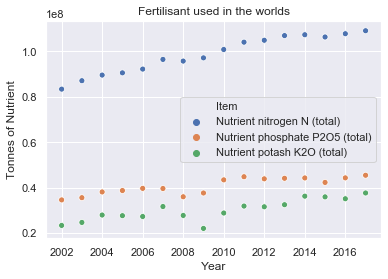

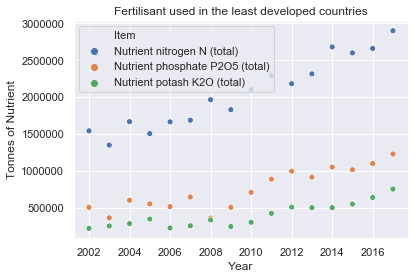

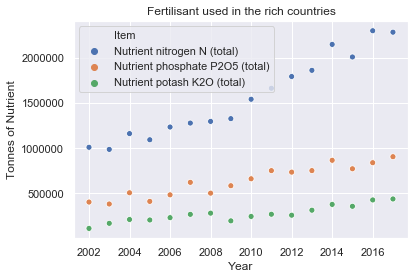

In [88]:
sns.scatterplot(x='Year',y='Value',hue='Item',data=Meltdf[Meltdf.Area=='World'])
plt.title('Fertilisant used in the worlds')
plt.ylabel('Tonnes of Nutrient')
plt.show()
sns.scatterplot(x='Year',y='Value',hue='Item',data=Meltdf[Meltdf.Area=='Least Developed Countries'])
plt.title('Fertilisant used in the least developed countries')
plt.ylabel('Tonnes of Nutrient')
plt.show()
sns.scatterplot(x='Year',y='Value',hue='Item',data=Meltdf[Meltdf.Area=='Land Locked Developing Countries'])
plt.title('Fertilisant used in the rich countries')
plt.ylabel('Tonnes of Nutrient')
plt.show()

To have an idee of the added value of fertilisant, lets start looking at the global density of fertilizers use and wheat production in tons:

In [ ]:
item = 'Wheat'
densityplotFertvsProdAll(item)

(3429, 7)


We cannot see any kind of linear correlation between the quantities of fertilisant used and production. The Indeed Data is just centralised in rectangular manner:

Let's have a closer look in USA's wheat production, here we still see no evident correlation.

In [ ]:
area = "United States of America"
item = 'Wheat'
Fertilisant = 'N' #N P K
plotFertandProd(area,item,Fertilisant)

area = "United States of America"
item = 'Wheat'
Fertilisant = 'P' #N P K
plotFertandProd(area,item,Fertilisant)

area = "United States of America"
item = 'Wheat'
Fertilisant = 'K' #N P K
plotFertandProd(area,item,Fertilisant)

In [ ]:
area = "United States of America"
item = 'Seed cotton'
Fertilisant = 'N' #N P K
plotFertandProd(area,item,Fertilisant)

area = "United States of America"
item = 'Seed cotton'
Fertilisant = 'P' #N P K
plotFertandProd(area,item,Fertilisant)

area = "United States of America"
item = 'Seed cotton'
Fertilisant = 'K' #N P K
plotFertandProd(area,item,Fertilisant)

In contrast the USA's seed production a shows more correlation:

In [ ]:
area = 'World'
item = 'Seed cotton'
Fertilisant = 'N' #N P K
plotFertandProd(area,item,Fertilisant)

area = "United States of America"
item = 'Seed cotton'
Fertilisant = 'P' #N P K
plotFertandProd(area,item,Fertilisant)

area = "United States of America"
item = 'Seed cotton'
Fertilisant = 'K' #N P K
plotFertandProd(area,item,Fertilisant)

One thing we have to care about is the fact that the more crop area is harvested, the more will be the production. So let's divide our production by the harvest area is h2 in order to diminish that bias.
Here, we plot the world average production in tons divided by harved area in hectars with the 3 fertilisants used.
In this case, we see a more direct correlation between fertilisant used and production (R2= ~0.75), which make difficult 
to ask farmer to use less fertlisant!:

In [ ]:
area = 'World'
item = 'Seed cotton'
RegScatterplotFertvsRatio(area,item)

But if we look at wheat production here USA, there is absolutly no correlation. One explanation is that once the field has sufficient ressources, adding fertilisant won't increase the production anymore. 
This means that no correlation indirectly involves that too much fertilisant is used:

In [ ]:
area = 'United States of America'
item = 'Wheat'
RegScatterplotFertvsRatio(area,item)

By looking in less rich and other countries, we see that the countries in devlepement have a linear corelation of fertilisant. 
This might come by the fact that they can't afford to saturate their field with artificial nutrient: 

In [ ]:
area = 'Least Developed Countries'
item = 'Wheat'
RegScatterplotFertvsRatio(area,item)

In [ ]:
area = 'Land Locked Developing Countries'
item = 'Wheat'
RegScatterplotFertvsRatio(area,item)

#### Q4 Conclusion

There is no direct relation of the time and ratio of production/fertilisant.
The use of fertilisant increase slowly with time consistant with the increased needs of the continuously rising population.

We can see that on world wide fertilisant used, the production is linearly correlated to fertilisant, but not on richer country. Indeed, rich country seem to over-saturate their field with artifical nutrient while the other countries are more cautious with the fertilisation.

We can conclude that richer countries might want to reduce their fertilisant use in order to avoid polution and waste. In opposition, some other countries should increase the fertilisant use in order to have more production.